In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
from joblib import Parallel, delayed
import joblib
from scipy import stats
%matplotlib inline

In [2]:
#for use on Casper
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=36,
                     processes=36, memory="375GB",
                     project='P93300641',
                     walltime='2:30:00')
cluster.scale(36)
client = Client(cluster)

In [19]:
client

Client Scheduler: tcp://10.12.205.30:34421 Dashboard: http://10.12.205.30:8787/status,Cluster Workers: 36 Cores: 36 Memory: 375.12 GB


### Some useful functions

In [8]:
def get_monthly(data_vars,firstyear=1850):
    """ retrieve monthly data from LENS2 using xarray

    Keyword arguments:
    data_vars -- list of required variables
    firstyear -- first year required for analysis
    
    Notes:
      * you don't need to ask for lat,lon,etc
      * the data are chunked by decade, so:
          firstyear =1995 yields [1990,2014]
      * you must be on casper for this to work (not cheyenne)
      * each 1d variable is 1.3GB/decade, consider taking only what you need :)
    """
    
    # find the ensemble directories
    topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
    mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))
    lnd    = '/lnd/proc/tseries/month_1/'
    # establish an ensemble dimension
    ensdim  = xr.DataArray(np.arange(len(mlist)), dims='ens', name='ens')
    ensdim.attrs['long_name']='ensemble number'
    # set up the year strings in each file
    yy1 = max(1850,10*int(firstyear/10))
    years = np.arange(yy1,2011,10)
    year_strs = []
    for year in years:
        if year<2001:
            yy = str(year)+'01-'+str(year+9)+'12'
        else:
            yy = '201001-201412'
        year_strs.append(yy)
        
    #read in the data
    firstvar = True
    for field in data_vars:
        dsets=[]
        for yy,year in zip(year_strs,years):
            paths = [glob.glob(mm+lnd+'*.h0.'+field+'.'+yy+'*')[0] for mm in mlist]
            ds_temp = xr.open_mfdataset(paths,combine='nested',decode_times=False,
                                        concat_dim=ensdim,parallel=True)[field]
            nmonths = len(ds_temp['time'])
            time_vec   = xr.cftime_range(str(year),periods=nmonths,freq='MS')
            ds_temp['time'] = time_vec
            dsets.append(ds_temp)

            if firstvar:    #need to instantiate ds
                firstvar = False
                mm = mlist[0]
                paths = [glob.glob(mm+lnd+'*.h0.'+field+'.'+yy+'*')[0] for yy in year_strs]
                ds = xr.open_mfdataset(paths,combine='by_coords')
                nmonths = len(ds['time'])
                time_vec   = xr.cftime_range(str(year),periods=nmonths,freq='MS')
                ds['time'] = time_vec

        ds[field] =xr.concat(dsets,dim='time')
    return ds

In [9]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [22]:
def detrend(x):
    t  = np.arange(len(x))
    m, b, r, p, std_err = stats.linregress(t,x)
    xdt = x-m*t-b
    return xdt

In [27]:
def regress(x,y):
    m, b, r, p, std_err = stats.linregress(x,y)
    xfit = np.array([x.min(),x.max()])
    yfit = m*xfit+b
    return m,r,xfit,yfit

In [10]:
# colorbrewer colormap, diverging, brown->green
ccc = np.zeros([11,3]);
ccc[0,:] = 84,48,5
ccc[1,:] = 140,81,10
ccc[2,:] = 191,129,45
ccc[3,:] = 223,194,125
ccc[4,:] = 246,232,195
ccc[5,:] = 245,245,245
ccc[6,:] = 199,234,229
ccc[7,:] = 128,205,193
ccc[8,:] = 53,151,143
ccc[9,:] = 1,102,94
ccc[10,:] = 0,60,48
ccc = matplotlib.colors.ListedColormap(ccc/256)

### Read in the data

In [20]:
%%time
data_vars = ['NBP','SOILLIQ']
firstyear = 2000
cesm2 = get_monthly(data_vars,firstyear)
cesm2['SW']=cesm2['SOILLIQ'].sum(dim='levsoi')


CPU times: user 5.36 s, sys: 1.28 s, total: 6.64 s
Wall time: 13.3 s


### Analysis

In [24]:
landarea = cesm2['area']*cesm2['landfrac']
ny = len(np.unique(cesm2['time.year']))
mth_wts = month_wts(ny)

xvar  = 'SW' 
xconv = 1/365*1e-9      #--> TtH2O
yvar  = 'NBP'
yconv = 24*60*60*1e-9   #--> PgC

#calculate global annual mean or sum
xglob = (landarea*cesm2[xvar]).sum(dim=['lat','lon']) 
xann  = xconv*(mth_wts*xglob).groupby('time.year').sum().load()
yglob = (landarea*cesm2[yvar]).sum(dim=['lat','lon']) 
yann  = yconv*(mth_wts*yglob).groupby('time.year').sum().load()

#detrend
xdt = []  
ydt = []
for ee in cesm2['ens']:
    x = xann.sel(ens=ee).values
    y = yann.sel(ens=ee).values
    xdt.append(detrend(x))
    ydt.append(detrend(y))

#regress
regressions = []
for ee in cesm2['ens'].values:
    out = regress(xdt[ee],ydt[ee])
    regressions.append(out)

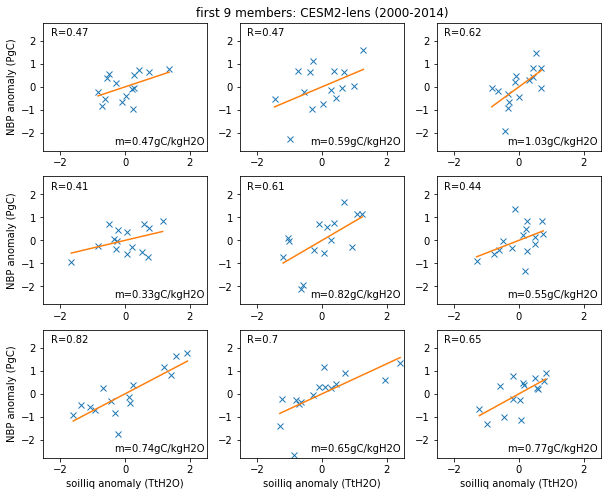

In [67]:
#PLOTTING
xlab = 'soilliq anomaly (TtH2O)'
ylab = 'NBP anomaly (PgC)'
# find x,ylims
nx = 9
xlim = 0
ylim = 0
for ee in range(nx):
    xlim = max(xlim,max(abs(xdt[ee])))
    ylim = max(ylim,max(abs(ydt[ee])))
xlim = 1.05*xlim
ylim = 1.05*ylim
    
plt.figure(figsize=[10,8])
for ee in range(nx):
    m,r,xfit,yfit = regressions[ee]
    plt.subplot(3,3,ee+1)
    plt.plot(xdt[ee],ydt[ee],'x')
    plt.plot(xfit,yfit)
    plt.xlim([-xlim,xlim])
    plt.ylim([-ylim,ylim])
    if (ee>5):
        plt.xlabel(xlab)
    if (ee==0)|(ee==3)|(ee==6):
        plt.ylabel(ylab)
    if (ee==1):
        plt.title('first 9 members: CESM2-lens (2000-2014)')
    plt.text(-0.35,-2.5,'m='+str(np.round(m,2))+'gC/kgH2O')
    plt.text(-2.3,2.2,'R='+str(np.round(r,2)))

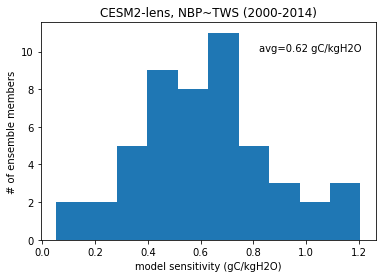

In [83]:
mvals = [out[0] for out in regressions]
plt.hist(mvals);
plt.xlabel('model sensitivity (gC/kgH2O)')
plt.ylabel('# of ensemble members')
plt.title('CESM2-lens, NBP~TWS (2000-2014)');
plt.text(0.82,10,'avg='+str(np.round(np.mean(mvals),2))+' gC/kgH2O');

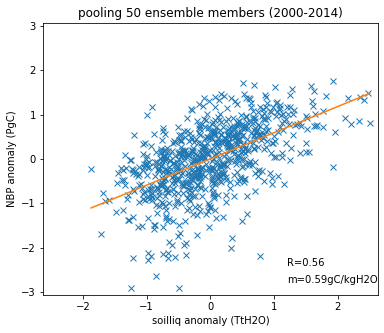

In [71]:
## pool all years together
nx = len(xdt)
ny = len(xdt[0])
x = np.zeros(nx*ny)
y = np.zeros(nx*ny)
for ee in range(nx):
    ix = ee*ny+np.arange(ny)
    x[ix] = xdt[ee]
    y[ix] = ydt[ee]
    
m,r,xfit,yfit = regress(x,y)
xlim = 1.05*max(abs(x))
ylim = 1.05*max(abs(y))
plt.figure(figsize=[6,5])
plt.plot(x,y,'x')
plt.plot(xfit,yfit)
plt.text(1.2,-2.8,'m='+str(np.round(m,2))+'gC/kgH2O')
plt.text(1.2,-2.4,'R='+str(np.round(r,2)))
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.xlim([-xlim,xlim])
plt.ylim([-ylim,ylim])
plt.title('pooling 50 ensemble members (2000-2014)');

In [7]:
def get_file(ee,model,field):
    if model == 'CESM1':
        topdir = ('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+
                  'lnd/proc/tseries/monthly/')
        matchme = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        lenskey = list(1+np.arange(35))+list(101+np.arange(7))
        nn      = lenskey[ee]
        ff = glob.glob(topdir+field+'/'+matchme+str(nn).zfill(3)+'*.nc')[0]
    else:
        topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))
        mm = mlist[ee]
        lnd    = '/lnd/proc/tseries/month_1/'
        yrs    = ['.200001-200912.','.201001-201412.']
        ff     = [glob.glob(mm+lnd+'*.'+field+yy+'*')[0] for yy in yrs]
    return ff

In [9]:
def one_regression(x,y):

    ny = len(x)
    #detrend TWS and NBP
    G0      = np.ones([ny,2])
    G0[:,1] = np.arange(ny)
    d       = x.reshape([-1,1])
    [m,sumr,r,s]=np.linalg.lstsq(G0,d,rcond=None)
    xa      = d-np.dot(G0,m)
    d       = y.reshape([-1,1])
    [m,sumr,r,s]=np.linalg.lstsq(G0,d,rcond=None)
    ya      = d-np.dot(G0,m)

    #regress
    G       = np.zeros([ny,1])
    G[:,0]  = xa.ravel()
    d       = ya
    [m,sumr,r,s]=np.linalg.lstsq(G,d,rcond=None)
    R       = np.corrcoef(xa.ravel(),ya.ravel())[0,1]
    
    return xa,ya,m,R

In [10]:
def two_regression(x1,x2,y):

    ny = len(x1)
    #detrend TWS and NBP
    G0      = np.ones([ny,2])
    G0[:,1] = np.arange(ny)
    
    d       = x1.reshape([-1,1])
    [m,sumr,r,s]=np.linalg.lstsq(G0,d,rcond=None)
    xa1     = d-np.dot(G0,m)
    
    d       = x2.reshape([-1,1])
    [m,sumr,r,s]=np.linalg.lstsq(G0,d,rcond=None)
    xa2     = d-np.dot(G0,m)
    
    d       = y.reshape([-1,1])
    [m,sumr,r,s]=np.linalg.lstsq(G0,d,rcond=None)
    ya      = d-np.dot(G0,m)

    #regress
    G       = np.ones([ny,2])
    G[:,0]  = xa1.ravel()
    G[:,1]  = xa2.ravel()
    d       = ya
    [m,sumr,r,s]=np.linalg.lstsq(G,d,rcond=None)
    
    return xa1,xa2,ya,m

In [11]:
#CESM1 header
ee = 0
model = 'CESM1'
soildim = 'levgrnd'
yy = 1990
ds1 = get_field(ee,model,'NBP')
ds2 = get_field(ee,model,'SOILLIQ')
nlat  = len(ds1['lat'])
nlon  = len(ds1['lon'])
latmap = np.tile(np.arange(nlat).reshape([-1,1]),[1,nlon])
lonmap = np.tile(np.arange(nlon).reshape([1,-1]),[nlat,1])
ixt   = ds1['time.year']>yy
nbp   = ds1['NBP'].isel(time=ixt)
tws   = ds2['SOILLIQ'].isel(time=ixt).sum(dim=soildim)
ix1   = nbp.std(dim='time')>0
ix2   = tws.std(dim='time')>0
ixlnd = np.logical_and(ix1,ix2)
lats = latmap[ixlnd]
lons = lonmap[ixlnd]
if model=='CESM2':
    landarea = ds1['area'].isel(time=0)*ds2['landfrac'].isel(time=0) #km2
else:
    landarea = ds1['area']*ds2['landfrac'] #km2
days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
nyears   = len(np.unique(tws['time.year']))
mth_wts  = xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [12]:
def myfunc_CESM1(ee):
    model = 'CESM1'
    yy = 1990
    #stuff to do once per ensemble member
    ds1   = get_field(ee,model,'NBP')
    ds2   = get_field(ee,model,'SOILLIQ')
    ds3   = get_field(ee,model,'TBOT')
    ixt   = ds1['time.year']>yy
    nbp   = ds1['NBP'].isel(time=ixt)
    tws   = ds2['SOILLIQ'].isel(time=ixt).sum(dim=soildim)
    tbot  = ds3['TBOT'].isel(time=ixt)

    tbotann = (mth_wts/365*tbot).groupby('time.year').sum().load()      # K
    tbotann_glob = 1/np.nansum(landarea)*(landarea*tbotann).sum(dim=['lat','lon'])

    nbpann = 24*60*60*(mth_wts*nbp).groupby('time.year').sum().load()   # gC/m2/yr
    nbpann_glob = 1e-15*1e6*((landarea*nbpann).sum(dim=['lat','lon'])).load()

    twsann = (mth_wts/365*tws).groupby('time.year').sum().load()        # mmH2O
    twsann_glob = 1e-15*1e6*((landarea*twsann).sum(dim=['lat','lon']))  # TTH20

    twsvar  = twsann.var(dim='year')
    twswts  = twsvar*landarea
    twswts  = twswts.fillna(0)
    twswts  = twswts/twswts.sum()
    twswts  = twswts.values

    tbotvar  = tbotann.var(dim='year')
    tbotwts  = tbotvar*landarea
    tbotwts  = tbotwts.fillna(0)
    tbotwts  = tbotwts/tbotwts.sum()
    tbotwts  = tbotwts.values

    xa1,ya,m1,R1 = one_regression(twsann_glob.values,nbpann_glob.values)
    xa2,ya,m2,R2 = one_regression(tbotann_glob.values,nbpann_glob.values)
    xa1,xa2,ya,m = two_regression(twsann_glob.values,tbotann_glob.values,nbpann_glob.values)

    tws_anoms  = np.zeros([nlat,nlon,len(xa1)])+np.nan
    tbot_anoms = np.zeros([nlat,nlon,len(xa1)])+np.nan
    nbp1_anoms = np.zeros([nlat,nlon,len(xa1)])+np.nan
    
    glob_out = [xa1,xa2,ya,m1,m2,m]
    
    mtws1   = np.zeros([nlat,nlon])+np.nan
    mtbot1  = np.zeros([nlat,nlon])+np.nan
    mtws2   = np.zeros([nlat,nlon])+np.nan
    mtbot2  = np.zeros([nlat,nlon])+np.nan
    
    for i,j in zip(lats,lons):

        x1 = twsann[:,i,j].values
        x2 = tbotann[:,i,j].values
        y  = nbpann[:,i,j].values

        xa1,ya,m1,R1 = one_regression(x1,y)
        xa2,ya,m2,R2 = one_regression(x2,y)
        xa1,xa2,ya,m = two_regression(x1,x2,y)

        tws_anoms[i,j,:]  = xa1.ravel()
        tbot_anoms[i,j,:] = xa2.ravel()
        nbp1_anoms[i,j,:] = ya.ravel()
        
        ya1 = ya-m[1,0]*xa2
        ya2 = ya-m[0,0]*xa1

        mtws1[i,j]  = m1 
        mtbot1[i,j] = m2
        mtws2[i,j]  = m[0,0]
        mtbot2[i,j] = m[1,0]

        #rtws1[i,j]  = R1 
        #rtbot1[i,j] = R2
        #rtws2[i,j]  = np.corrcoef(xa1.ravel(),ya1.ravel())[0,1]
        #rtbot2[i,j] = np.corrcoef(xa2.ravel(),ya2.ravel())[0,1]
    
        pix_out = [mtws1,mtws2,mtbot1,mtbot2,twswts,tbotwts,tws_anoms,tbot_anoms,nbp1_anoms]
    
    
    return glob_out,pix_out

In [13]:
%%time
with joblib.parallel_backend('dask'):
    x1 = Parallel()(delayed(myfunc_CESM1)(ee) for ee in range(21))
with joblib.parallel_backend('dask'):
    x2 = Parallel()(delayed(myfunc_CESM1)(ee) for ee in 21+np.arange(21))
CESM1 = x1+x2

CPU times: user 5.4 s, sys: 2.45 s, total: 7.85 s
Wall time: 1min 33s


In [14]:
#CESM2 header
ee = 0
model = 'CESM2'
soildim = 'levsoi'
yy = 1999
ds1 = get_field(ee,model,'NBP')
ds2 = get_field(ee,model,'SOILLIQ')
nlat  = len(ds1['lat'])
nlon  = len(ds1['lon'])
latmap = np.tile(np.arange(nlat).reshape([-1,1]),[1,nlon])
lonmap = np.tile(np.arange(nlon).reshape([1,-1]),[nlat,1])
ixt   = ds1['time.year']>yy
nbp   = ds1['NBP'].isel(time=ixt)
tws   = ds2['SOILLIQ'].isel(time=ixt).sum(dim=soildim)
ix1   = nbp.std(dim='time')>0
ix2   = tws.std(dim='time')>0
ixlnd = np.logical_and(ix1,ix2)
lats = latmap[ixlnd]
lons = lonmap[ixlnd]
if model=='CESM2':
    landarea = ds1['area'].isel(time=0)*ds2['landfrac'].isel(time=0) #km2
else:
    landarea = ds1['area']*ds2['landfrac'] #km2
days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
nyears   = len(np.unique(tws['time.year']))
mth_wts  = xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [15]:
def myfunc_CESM2(ee):
    model = 'CESM2'
    yy = 1999
    #stuff to do once per ensemble member
    ds1   = get_field(ee,model,'NBP')
    ds2   = get_field(ee,model,'SOILLIQ')
    ds3   = get_field(ee,model,'TBOT')
    ixt   = ds1['time.year']>yy
    nbp   = ds1['NBP'].isel(time=ixt)
    tws   = ds2['SOILLIQ'].isel(time=ixt).sum(dim=soildim)
    tbot  = ds3['TBOT'].isel(time=ixt)

    tbotann = (mth_wts/365*tbot).groupby('time.year').sum().load()      # K
    tbotann_glob = 1/np.nansum(landarea)*(landarea*tbotann).sum(dim=['lat','lon'])

    nbpann = 24*60*60*(mth_wts*nbp).groupby('time.year').sum().load()   # gC/m2/yr
    nbpann_glob = 1e-15*1e6*((landarea*nbpann).sum(dim=['lat','lon'])).load()

    twsann = (mth_wts/365*tws).groupby('time.year').sum().load()        # mmH2O
    twsann_glob = 1e-15*1e6*((landarea*twsann).sum(dim=['lat','lon']))  # TTH20

    twsvar  = twsann.var(dim='year')
    twswts  = twsvar*landarea
    twswts  = twswts.fillna(0)
    twswts  = twswts/twswts.sum()
    twswts  = twswts.values

    tbotvar  = tbotann.var(dim='year')
    tbotwts  = tbotvar*landarea
    tbotwts  = tbotwts.fillna(0)
    tbotwts  = tbotwts/tbotwts.sum()
    tbotwts  = tbotwts.values

    xa1,ya,m1,R1 = one_regression(twsann_glob.values,nbpann_glob.values)
    xa2,ya,m2,R2 = one_regression(tbotann_glob.values,nbpann_glob.values)
    xa1,xa2,ya,m = two_regression(twsann_glob.values,tbotann_glob.values,nbpann_glob.values)

    
    glob_out = [xa1,xa2,ya,m1,m2,m]
    
    tws_anoms  = np.zeros([nlat,nlon,len(xa1)])+np.nan
    tbot_anoms = np.zeros([nlat,nlon,len(xa1)])+np.nan
    nbp1_anoms = np.zeros([nlat,nlon,len(xa1)])+np.nan
    
    mtws1   = np.zeros([nlat,nlon])+np.nan
    mtbot1  = np.zeros([nlat,nlon])+np.nan
    mtws2   = np.zeros([nlat,nlon])+np.nan
    mtbot2  = np.zeros([nlat,nlon])+np.nan
    
    for i,j in zip(lats,lons):

        x1 = twsann[:,i,j].values
        x2 = tbotann[:,i,j].values
        y  = nbpann[:,i,j].values

        xa1,ya,m1,R1 = one_regression(x1,y)
        xa2,ya,m2,R2 = one_regression(x2,y)
        xa1,xa2,ya,m = two_regression(x1,x2,y)

        tws_anoms[i,j,:]  = xa1.ravel()
        tbot_anoms[i,j,:] = xa2.ravel()
        nbp1_anoms[i,j,:] = ya.ravel()
        
        ya1 = ya-m[1,0]*xa2
        ya2 = ya-m[0,0]*xa1

        mtws1[i,j]  = m1 
        mtbot1[i,j] = m2
        mtws2[i,j]  = m[0,0]
        mtbot2[i,j] = m[1,0]

        #rtws1[i,j]  = R1 
        #rtbot1[i,j] = R2
        #rtws2[i,j]  = np.corrcoef(xa1.ravel(),ya1.ravel())[0,1]
        #rtbot2[i,j] = np.corrcoef(xa2.ravel(),ya2.ravel())[0,1]
    
        pix_out = [mtws1,mtws2,mtbot1,mtbot2,twswts,tbotwts,tws_anoms,tbot_anoms,nbp1_anoms]
    
    
    return glob_out,pix_out

In [16]:
%%time
with joblib.parallel_backend('dask'):
    x1 = Parallel()(delayed(myfunc_CESM2)(ee) for ee in range(25))
with joblib.parallel_backend('dask'):
    x2 = Parallel()(delayed(myfunc_CESM2)(ee) for ee in 25+np.arange(25))
CESM2 = x1+x2

CPU times: user 15 s, sys: 4.22 s, total: 19.3 s
Wall time: 2min 27s


In [75]:
tws  = np.zeros(42*15)
err1 = np.zeros(42*15)
err2 = np.zeros(42*15)
i = 0

for out in CESM1:
    ix  = i*15+np.arange(15)

    xa1,xa2,ya,m1,m2,m = out[0]
    mtws1,mtws2,mtbot1,mtbot2,twswts,tbotwts,tws_anoms,tbot_anoms,nbp1_anoms = out[1]

    tws[ix]  = xa1.ravel()

    nbp_grid = 1e6*landarea.values[:,:,np.newaxis]*mtws1[:,:,np.newaxis]*tws_anoms  #gC/yr/gridcell
    nbp      = 1e-15*np.nansum(nbp_grid,axis=(0,1))  #PgC
    err1[ix] = nbp-ya.ravel()

    nbp_grid = 1e6*landarea.values[:,:,np.newaxis]*(mtws2[:,:,np.newaxis]*tws_anoms
                                                    +mtbot2[:,:,np.newaxis]*tbot_anoms) #gC/yr/gridcell
    nbp      = 1e-15*np.nansum(nbp_grid,axis=(0,1))  #PgC
    err2[ix] = nbp-ya.ravel()


    i += 1


(-2.25, 2.25)

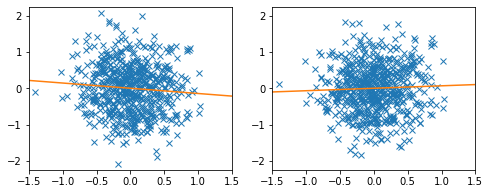

In [89]:
#regress
ny = len(tws)
G       = np.ones([ny,2])
G[:,1]  = tws
d       = err1
[m,sumr,r,s]=np.linalg.lstsq(G,d,rcond=None)
m1 = m[1]
d       = err2
[m,sumr,r,s]=np.linalg.lstsq(G,d,rcond=None)
m2 = m[1]


xfit = np.array([-1.5,1.5])

plt.figure(figsize=[8,3])
plt.subplot(121)
plt.plot(tws,err1,'x')
plt.plot(xfit,m1*xfit)
plt.xlim([-1.5,1.5])
plt.ylim([-2.25,2.25])

plt.subplot(122)
plt.plot(tws,err2,'x')
plt.plot(xfit,m2*xfit)
plt.xlim([-1.5,1.5])
plt.ylim([-2.25,2.25])

In [120]:
tws  = np.zeros(50*15)
tbot = np.zeros(50*15)
err1 = np.zeros(50*15)
err1b = np.zeros(50*15)
err2 = np.zeros(50*15)
nbp0 = np.zeros(50*15)
nbp1 = np.zeros(50*15)
nbp2 = np.zeros(50*15)
i = 0

for out in CESM2:
    ix  = i*15+np.arange(15)

    xa1,xa2,ya,m1,m2,m = out[0]
    
    nbp0[ix] = ya.ravel()
    nbp1[ix] = (ya-m[1]*xa2).ravel()
    nbp2[ix] = (ya-m[0]*xa1).ravel()
    
    
    mtws1,mtws2,mtbot1,mtbot2,twswts,tbotwts,tws_anoms,tbot_anoms,nbp1_anoms = out[1]

    tws[ix]  = xa1.ravel()
    tbot[ix] = xa2.ravel()

    nbp_grid = 1e6*landarea.values[:,:,np.newaxis]*mtws1[:,:,np.newaxis]*tws_anoms  #gC/yr/gridcell
    nbp      = 1e-15*np.nansum(nbp_grid,axis=(0,1))  #PgC
    err1[ix] = nbp-ya.ravel()
    
    nbp_grid  = 1e6*landarea.values[:,:,np.newaxis]*mtbot1[:,:,np.newaxis]*tbot_anoms  #gC/yr/gridcell
    nbp       = 1e-15*np.nansum(nbp_grid,axis=(0,1))  #PgC
    err1b[ix] = nbp-ya.ravel()

    
    
    
    nbp_grid = 1e6*landarea.values[:,:,np.newaxis]*(mtws2[:,:,np.newaxis]*tws_anoms
                                                    +mtbot2[:,:,np.newaxis]*tbot_anoms) #gC/yr/gridcell
    nbp      = 1e-15*np.nansum(nbp_grid,axis=(0,1))  #PgC
    err2[ix] = nbp-ya.ravel()


    i += 1


-0.775376865032514
-0.22804729145322414


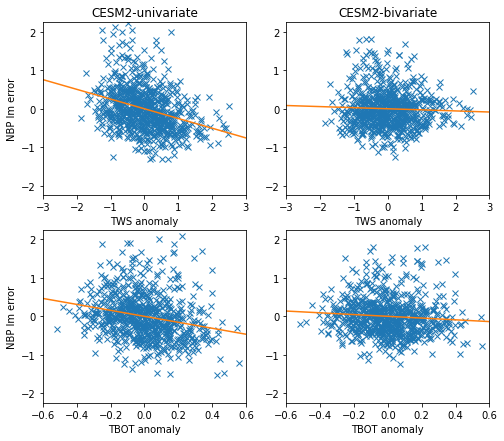

In [129]:
#regress
ny = len(tws)
G       = np.ones([ny,2])

G[:,1]  = tws
d       = err1
[m,sumr,r,s]=np.linalg.lstsq(G,d,rcond=None)
m1 = m[1]
d       = err2
[m,sumr,r,s]=np.linalg.lstsq(G,d,rcond=None)
m2 = m[1]

G[:,1]  = tbot
d       = err1b
[m,sumr,r,s]=np.linalg.lstsq(G,d,rcond=None)
m3 = m[1]
d       = err2
[m,sumr,r,s]=np.linalg.lstsq(G,d,rcond=None)
m4 = m[1]

xfit = np.array([-3,3])

plt.figure(figsize=[8,7])

plt.subplot(221)
plt.plot(tws,err1,'x')
plt.plot(xfit,m1*xfit)
plt.xlim(xfit)
plt.ylim([-2.25,2.25])
plt.xlabel('TWS anomaly')
plt.ylabel('NBP lm error')
plt.title('CESM2-univariate')

plt.subplot(222)
plt.plot(tws,err2,'x')
plt.plot(xfit,m2*xfit)
plt.xlim(xfit)
plt.ylim([-2.25,2.25])
plt.xlabel('TWS anomaly')
plt.title('CESM2-bivariate');


xfit = np.array([-0.6,0.6])
plt.subplot(223)
plt.plot(tbot,err1b,'x')
plt.plot(xfit,m3*xfit)
plt.xlim(xfit)
plt.ylim([-2.25,2.25])
plt.xlabel('TBOT anomaly')
plt.ylabel('NBP lm error')

plt.subplot(224)
plt.plot(tbot,err2,'x')
plt.plot(xfit,m4*xfit)
plt.xlim(xfit)
plt.ylim([-2.25,2.25])
plt.xlabel('TBOT anomaly');
print(m3)
print(m4)


In [133]:
#regress
ny = len(tws)
G       = np.ones([ny,2])

G[:,1]  = tws
d       = nbp0
[m,sumr,r,s]=np.linalg.lstsq(G,d,rcond=None)
m1 = m[1]
d       = nbp1
[m,sumr,r,s]=np.linalg.lstsq(G,d,rcond=None)
m2 = m[1]

G[:,1]  = tbot
d       = nbp0
[m,sumr,r,s]=np.linalg.lstsq(G,d,rcond=None)
m3 = m[1]
d       = nbp2
[m,sumr,r,s]=np.linalg.lstsq(G,d,rcond=None)
m4 = m[1]

print(m3)
print(m4)

-1.8287519144908118
-0.7551568538902588


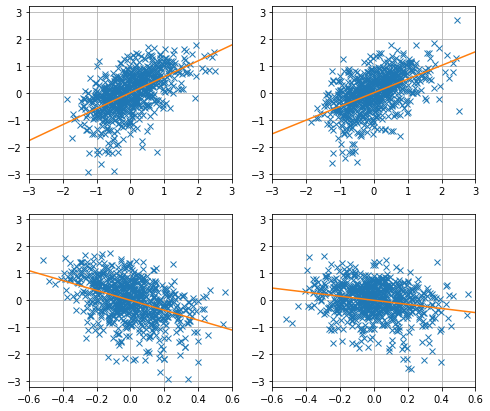

In [135]:
plt.figure(figsize=[8,7])

xfit = np.array([-3,3])

plt.subplot(221)
plt.plot(tws,nbp0,'x')
plt.plot(xfit,m1*xfit)
plt.ylim([-3.2,3.2])
plt.xlim(xfit)
plt.grid()

plt.subplot(222)
plt.plot(tws,nbp1,'x')
plt.plot(xfit,m2*xfit)
plt.xlim(xfit)
plt.ylim([-3.2,3.2])
plt.grid()

xfit = np.array([-0.6,0.6])

plt.subplot(223)
plt.plot(tbot,nbp0,'x')
plt.plot(xfit,m3*xfit)
plt.ylim([-3.2,3.2])
plt.xlim(xfit)
plt.grid()

plt.subplot(224)
plt.plot(tbot,nbp2,'x')
plt.plot(xfit,m4*xfit)
plt.xlim(xfit)
plt.ylim([-3.2,3.2])
plt.grid()

0.22802741859125977
0.16586928650307925


In [184]:
ny = 15
G       = np.ones([ny,2])
mvals1 = np.zeros(50)
mvals2 = np.zeros(50)

i=0
for out in CESM2:

    xa1,xa2,ya,m1,m2,m = out[0]
    mtws1,mtws2,mtbot1,mtbot2,twswts,tbotwts,tws_anoms,tbot_anoms,nbp1_anoms = out[1]

    nbp_grid = 1e6*landarea.values[:,:,np.newaxis]*mtws2[:,:,np.newaxis]*tws_anoms
    tws      = xa1.ravel()
    nbp      = 1e-15*np.nansum(nbp_grid,axis=(0,1))
    
    G[:,1]  = tws
    d       = nbp.reshape([-1,1])
    [m,sumr,r,s]=np.linalg.lstsq(G,d,rcond=None)
    mvals1[i] = m[1,0]
    
    mvals2[i] = np.nansum(mtws2*twswts)
    
    i +=1

(0.05, 0.55)

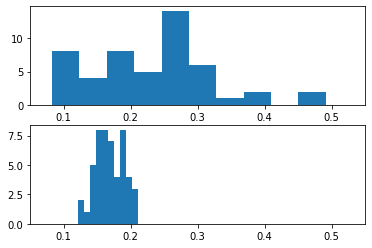

In [189]:
plt.subplot(211)
plt.hist(mvals1)
plt.xlim([0.05,0.55])
plt.subplot(212)
plt.hist(mvals2)
plt.xlim([0.05,0.55])

In [186]:
np.mean(mvals1)

0.23459102450419628

In [187]:
np.mean(mvals2)

0.16867923736616247

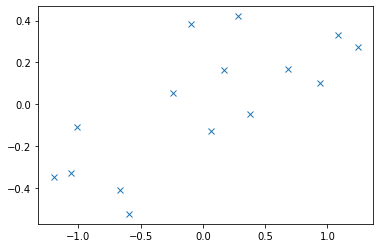

In [176]:
plt.plot(tws,nbp,'x')

(-200.0, 200.0)

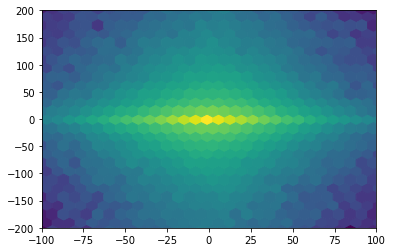

In [27]:
plt.hexbin(tws,err,bins='log')
plt.xlim([-100,100])
plt.ylim([-200,200])

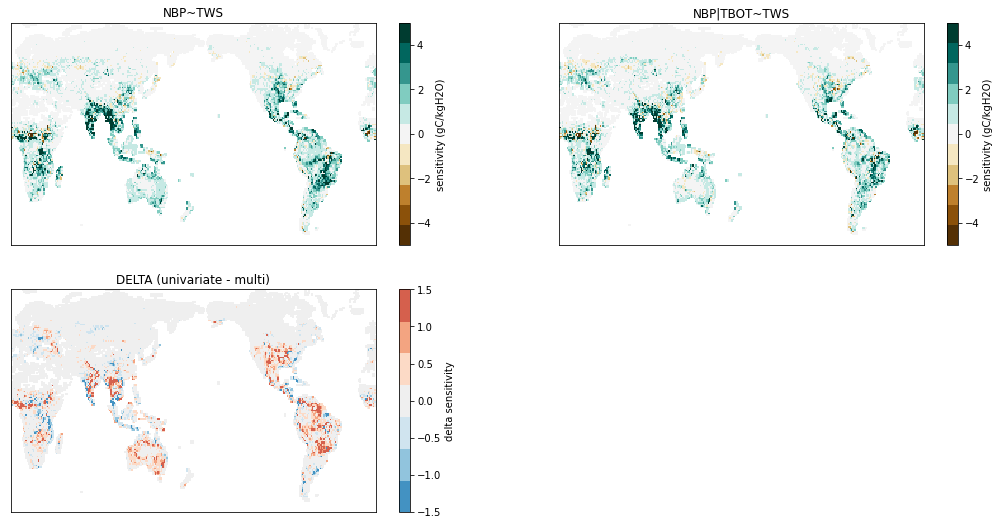

In [32]:
out = CESM1[2]
mtws1,mtws2,mtbot1,mtbot2,twswts,tbotwts,tws_anoms,tbot_anoms,nbp1_anoms = out[1]


plt.figure(figsize=[18,9])
plt.subplot(221)
plt.pcolormesh(mtws1,vmin=-5,vmax=5,cmap=ccc)
plt.colorbar(label='sensitivity (gC/kgH2O)')
plt.ylim([30,180])
plt.xticks([])
plt.yticks([])
plt.title('NBP~TWS')

plt.subplot(222)
plt.pcolormesh(mtws2,vmin=-5,vmax=5,cmap=ccc)
plt.colorbar(label='sensitivity (gC/kgH2O)')
plt.ylim([30,180])
plt.xticks([])
plt.yticks([])
plt.title('NBP|TBOT~TWS')

plt.subplot(223)
plt.pcolormesh(mtws1-mtws2,vmin=-1.5,vmax=1.5,cmap=ccc2)
plt.colorbar(label='delta sensitivity')
plt.ylim([30,180])
plt.xticks([])
plt.yticks([])
plt.title('DELTA (univariate - multi)');

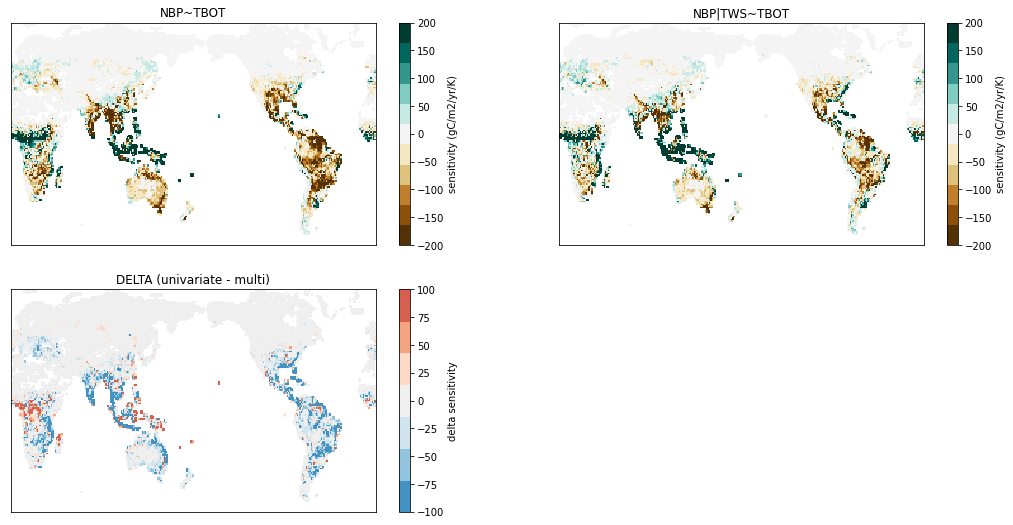

In [34]:
plt.figure(figsize=[18,9])
plt.subplot(221)
plt.pcolormesh(mtbot1,vmin=-200,vmax=200,cmap=ccc)
plt.colorbar(label='sensitivity (gC/m2/yr/K)')
plt.ylim([30,180])
plt.xticks([])
plt.yticks([])
plt.title('NBP~TBOT')

plt.subplot(222)
plt.pcolormesh(mtbot2,vmin=-200,vmax=200,cmap=ccc)
plt.colorbar(label='sensitivity (gC/m2/yr/K)')
plt.ylim([30,180])
plt.xticks([])
plt.yticks([])
plt.title('NBP|TWS~TBOT')

plt.subplot(223)
plt.pcolormesh(mtbot1-mtbot2,vmin=-100,vmax=100,cmap=ccc2)
plt.colorbar(label='delta sensitivity')
plt.ylim([30,180])
plt.xticks([])
plt.yticks([])
plt.title('DELTA (univariate - multi)');

In [35]:
import warnings
warnings.filterwarnings("ignore")

In [36]:
lnd_tot = landarea.where(ixlnd).sum().values #km2
xv = np.linspace(-2,5,11)
tv = np.linspace(-25,10,11)
x  = 0.5*(xv[:-1]+xv[1:])
t  = 0.5*(tv[:-1]+tv[1:])
nx = len(xv)-1
out1 = np.zeros(nx)
out2 = np.zeros(nx)
out3 = np.zeros(nx)
out4 = np.zeros(nx)

tb1 = lnd_tot*1e6*1e-15*mtbot1
tb2 = lnd_tot*1e6*1e-15*mtbot2

for i in range(nx):
    ix = np.logical_and(mtws1>xv[i],mtws1<=xv[i+1])
    out1[i] = np.sum(twswts[ix])
    ix = np.logical_and(mtws2>xv[i],mtws2<=xv[i+1])
    out2[i] = np.sum(twswts[ix])
    
    ix = np.logical_and(tb1>tv[i],tb1<=tv[i+1])
    out3[i] = np.sum(tbotwts[ix])
    ix = np.logical_and(tb2>tv[i],tb2<=tv[i+1])
    out4[i] = np.sum(tbotwts[ix])
    
  

Mavg(NBP~TWS)      = 0.75PgC/TtH2O
Mavg(NBP|TBOT~TWS) = 0.63PgC/TtH2O

Mavg(NBP~TWS)      = -1.58PgC/K
Mavg(NBP|TBOT~TWS) = -0.9PgC/K



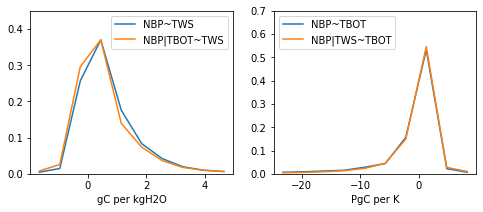

In [37]:
mavg1 = np.nansum(twswts*mtws1)  # PgC / TtH2O
mavg2 = np.nansum(twswts*mtws2)  # PgC / TtH2O


mavg3 = lnd_tot*1e6*1e-15*np.nansum(tbotwts*mtbot1) # PgC / K
mavg4 = lnd_tot*1e6*1e-15*np.nansum(tbotwts*mtbot2) # PgC / K




plt.figure(figsize=[8,3])
plt.subplot(121)
plt.plot(x,out1)
plt.plot(x,out2)
plt.legend(['NBP~TWS','NBP|TBOT~TWS'])
print('Mavg(NBP~TWS)      = '+str(np.round(mavg1,2))+'PgC/TtH2O')
print('Mavg(NBP|TBOT~TWS) = '+str(np.round(mavg2,2))+'PgC/TtH2O')
plt.ylim([0,0.45])
plt.xlabel('gC per kgH2O')

plt.subplot(122)
plt.plot(t,out3)
plt.plot(t,out4)
plt.legend(['NBP~TBOT','NBP|TWS~TBOT'])
plt.ylim([0,0.7])
plt.xlabel('PgC per K')

print('')
print('Mavg(NBP~TWS)      = '+str(np.round(mavg3,2))+'PgC/K')
print('Mavg(NBP|TBOT~TWS) = '+str(np.round(mavg4,2))+'PgC/K')
print('')

In [55]:
tws1  = np.zeros(42*15)
tbot1 = np.zeros(42*15)
nbp  = np.zeros(42*15)

i = 0
for out in CESM1:
    xa1 = out[0][0]
    xa2 = out[0][1]
    ya  = out[0][2]
    
    ix = np.arange(15)+i*15
    tws1[ix]  = xa1.ravel()
    tbot1[ix] = xa2.ravel()
    nbp[ix]  = ya.ravel()
    
    i += 1

m1, b1, r1, p1, std_err = stats.linregress(tws1,nbp)
m2, b2, r2, p2, std_err = stats.linregress(tbot1,nbp)

G = np.zeros([42*15,2])
G[:,0] = tws1
G[:,1] = tbot1
d      = nbp.reshape([-1,1])
[m,sumr,r,s]=np.linalg.lstsq(G,d,rcond=None)
m

nbp_tws  = nbp-tbot1*m[1,0]
nbp_tbot = nbp-tws1*m[0,0]

r3 = np.corrcoef(tws1,nbp_tws)[0,1]
r4 = np.corrcoef(tbot1,nbp_tbot)[0,1]


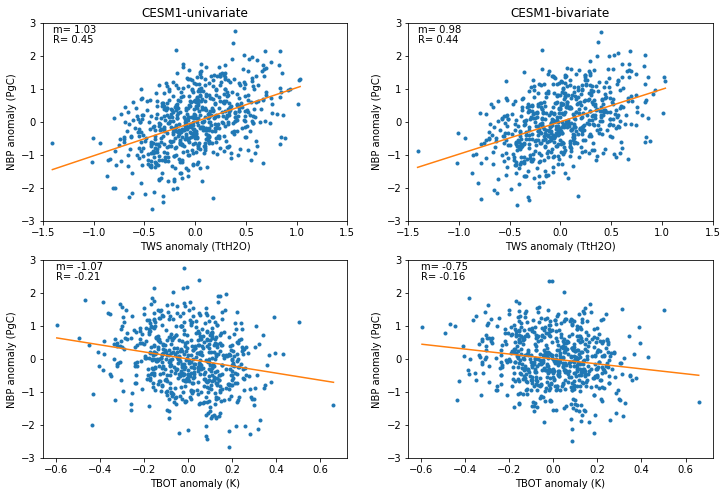

In [56]:
plt.figure(figsize=[12,8])

plt.subplot(221)
xfit = np.sort(tws1)
plt.plot(tws1,nbp,'.')
plt.plot(xfit,m1*xfit)
plt.title('CESM1-univariate')
plt.ylabel('NBP anomaly (PgC)')
plt.xlabel('TWS anomaly (TtH2O)')
plt.text(-1.4,2.7,'m= '+str(np.round(m1,2)))
plt.text(-1.4,2.4,'R= '+str(np.round(r1,2)))
plt.ylim([-3,3])
plt.xlim([-1.5,1.5])

plt.subplot(222)
plt.plot(tws1,nbp_tws,'.')
plt.plot(xfit,m[0,0]*xfit)
plt.title('CESM1-bivariate')
plt.ylabel('NBP anomaly (PgC)')
plt.xlabel('TWS anomaly (TtH2O)')
plt.text(-1.4,2.7,'m= '+str(np.round(m[0,0],2)))
plt.text(-1.4,2.4,'R= '+str(np.round(r3,2)))
plt.ylim([-3,3])
plt.xlim([-1.5,1.5])

plt.subplot(223)
xfit = np.sort(tbot1)
plt.plot(tbot1,nbp,'.')
plt.plot(xfit,m2*xfit)
plt.ylabel('NBP anomaly (PgC)')
plt.xlabel('TBOT anomaly (K)')
plt.text(-0.6,2.7,'m= '+str(np.round(m2,2)))
plt.text(-0.6,2.4,'R= '+str(np.round(r2,2)))
plt.ylim([-3,3])

plt.subplot(224)

plt.plot(tbot1,nbp_tbot,'.')
plt.plot(xfit,m[1,0]*xfit)
plt.ylabel('NBP anomaly (PgC)')
plt.xlabel('TBOT anomaly (K)')
plt.text(-0.6,2.7,'m= '+str(np.round(m[1,0],2)))
plt.text(-0.6,2.4,'R= '+str(np.round(r4,2)))
plt.ylim([-3,3]);

In [57]:
tws2  = np.zeros(50*15)
tbot2 = np.zeros(50*15)
nbp  = np.zeros(50*15)

i = 0
for out in CESM2:
    xa1 = out[0][0]
    xa2 = out[0][1]
    ya  = out[0][2]
    
    ix = np.arange(15)+i*15
    tws2[ix]  = xa1.ravel()
    tbot2[ix] = xa2.ravel()
    nbp[ix]  = ya.ravel()
    
    i += 1

m1, b1, r1, p1, std_err = stats.linregress(tws2,nbp)
m2, b2, r2, p2, std_err = stats.linregress(tbot2,nbp)

G = np.zeros([50*15,2])
G[:,0] = tws2
G[:,1] = tbot2
d      = nbp.reshape([-1,1])
[m,sumr,r,s]=np.linalg.lstsq(G,d,rcond=None)
m

nbp_tws  = nbp-tbot2*m[1,0]
nbp_tbot = nbp-tws2*m[0,0]

r3 = np.corrcoef(tws2,nbp_tws)[0,1]
r4 = np.corrcoef(tbot2,nbp_tbot)[0,1]


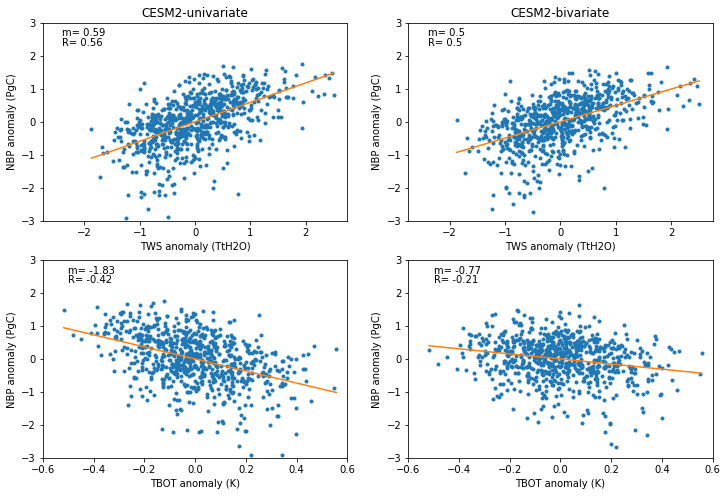

In [58]:
plt.figure(figsize=[12,8])

plt.subplot(221)
xfit = np.sort(tws2)
plt.plot(tws2,nbp,'.')
plt.plot(xfit,m1*xfit)
plt.title('CESM2-univariate')
plt.ylabel('NBP anomaly (PgC)')
plt.xlabel('TWS anomaly (TtH2O)')
plt.text(-2.4,2.6,'m= '+str(np.round(m1,2)))
plt.text(-2.4,2.3,'R= '+str(np.round(r1,2)))
plt.ylim([-3,3])
plt.xlim([-2.75,2.75])

plt.subplot(222)
plt.plot(tws2,nbp_tws,'.')
plt.plot(xfit,m[0,0]*xfit)
plt.title('CESM2-bivariate')
plt.ylabel('NBP anomaly (PgC)')
plt.xlabel('TWS anomaly (TtH2O)')
plt.text(-2.4,2.6,'m= '+str(np.round(m[0,0],2)))
plt.text(-2.4,2.3,'R= '+str(np.round(r3,2)))
plt.ylim([-3,3])
plt.xlim([-2.75,2.75])

plt.subplot(223)
xfit = np.sort(tbot2)
plt.plot(tbot2,nbp,'.')
plt.plot(xfit,m2*xfit)
plt.ylabel('NBP anomaly (PgC)')
plt.xlabel('TBOT anomaly (K)')
plt.text(-0.5,2.6,'m= '+str(np.round(m2,2)))
plt.text(-0.5,2.3,'R= '+str(np.round(r2,2)))
plt.ylim([-3,3])
plt.xlim([-0.6,0.6])

plt.subplot(224)
plt.plot(tbot2,nbp_tbot,'.')
plt.plot(xfit,m[1,0]*xfit)
plt.ylabel('NBP anomaly (PgC)')
plt.xlabel('TBOT anomaly (K)')
plt.text(-0.5,2.6,'m= '+str(np.round(m[1,0],2)))
plt.text(-0.5,2.3,'R= '+str(np.round(r4,2)))
plt.ylim([-3,3])
plt.xlim([-0.6,0.6]);

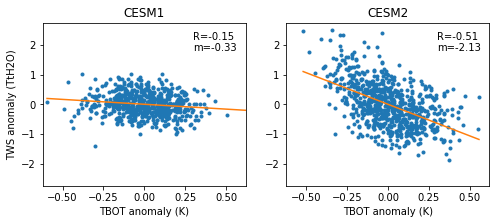

In [83]:
G = np.ones([42*15,2])
G[:,1] = tbot1
d      = tws1.reshape([-1,1])
[m,sumr,r,s]=np.linalg.lstsq(G,d,rcond=None)
Gfit = np.ones([2,2])
x = [tbot1.min(),tbot1.max()]
Gfit[:,1] = x
yfit = np.dot(Gfit,m)
r = np.corrcoef(tbot1,tws1)[0,1]


plt.figure(figsize=[8,3])
plt.subplot(121)
plt.plot(tbot1,tws1,'.')
plt.plot(x,yfit)
plt.text(0.3,2.2,'R='+str(np.round(r,2)))
plt.text(0.3,1.8,'m='+str(np.round(m[1,0],2)))
plt.xlim([-0.62,0.62])
plt.ylim([-2.75,2.75])
plt.ylabel('TWS anomaly (TtH2O)')
plt.xlabel('TBOT anomaly (K)')
plt.title('CESM1');

G = np.ones([50*15,2])
G[:,1] = tbot2
d      = tws2.reshape([-1,1])
[m,sumr,r,s]=np.linalg.lstsq(G,d,rcond=None)
Gfit = np.ones([2,2])
x = [tbot2.min(),tbot2.max()]
Gfit[:,1] = x
yfit = np.dot(Gfit,m)
r = np.corrcoef(tbot2,tws2)[0,1]

plt.subplot(122)
plt.plot(tbot2,tws2,'.')
plt.plot(x,yfit)
plt.text(0.3,2.2,'R='+str(np.round(r,2)))
plt.text(0.3,1.8,'m='+str(np.round(m[1,0],2)))
plt.xlim([-0.62,0.62])
plt.ylim([-2.75,2.75])
plt.xlabel('TBOT anomaly (K)')
plt.title('CESM2');

In [108]:
mavg1 = np.zeros([nlat,nlon])
tw1   = np.zeros([nlat,nlon])
nb1   = np.zeros([nlat,nlon])
for out in CESM1:
    mtws1,mtws2,mtbot1,mtbot2,twswts,tbotwts,tws_anoms,tbot_anoms,nbp1_anoms = out[1]
    mavg1 = mavg1 +1/42*mtws1
    tw1   = tw1+ 1/42*np.std(tws_anoms,axis=2)
    nb1   = nb1+ 1/42*np.std(nbp1_anoms,axis=2)
    
mavg2 = np.zeros([nlat,nlon])
tw2   = np.zeros([nlat,nlon])
nb2   = np.zeros([nlat,nlon])
for out in CESM2:
    mtws1,mtws2,mtbot1,mtbot2,twswts,tbotwts,tws_anoms,tbot_anoms,nbp1_anoms = out[1]
    mavg2 = mavg2 +1/50*mtws1
    tw2   = tw2+ 1/50*np.std(tws_anoms,axis=2)
    nb2   = nb2+ 1/50*np.std(nbp1_anoms,axis=2)

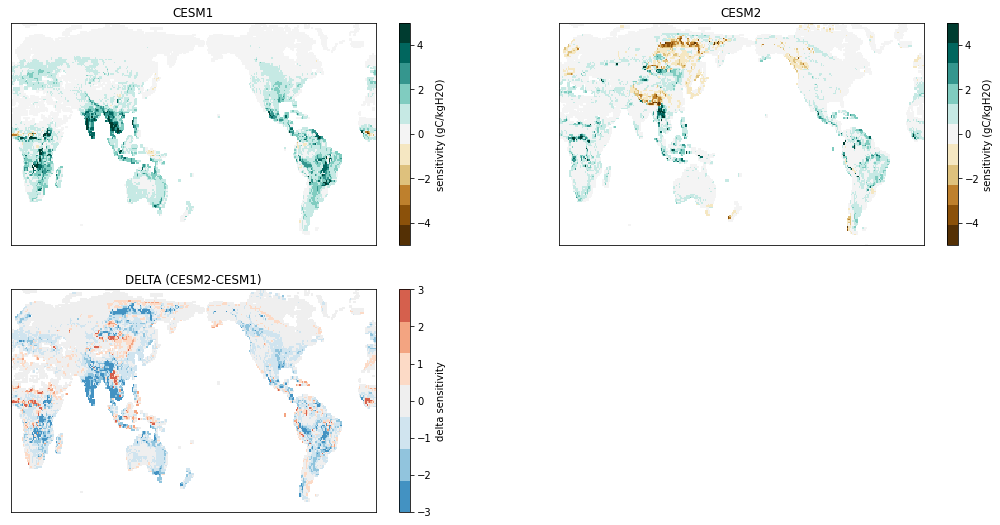

In [113]:
plt.figure(figsize=[18,9])
plt.subplot(221)
plt.pcolormesh(mavg1,vmin=-5,vmax=5,cmap=ccc)
plt.colorbar(label='sensitivity (gC/kgH2O)')
plt.ylim([30,180])
plt.xticks([])
plt.yticks([])
plt.title('CESM1')

plt.subplot(222)
plt.pcolormesh(mavg2,vmin=-5,vmax=5,cmap=ccc)
plt.colorbar(label='sensitivity (gC/kgH2O)')
plt.ylim([30,180])
plt.xticks([])
plt.yticks([])
plt.title('CESM2')

plt.subplot(223)
plt.pcolormesh(mavg2-mavg1,vmin=-3,vmax=3,cmap=ccc2)
plt.colorbar(label='delta sensitivity')
plt.ylim([30,180])
plt.xticks([])
plt.yticks([])
plt.title('DELTA (CESM2-CESM1)');

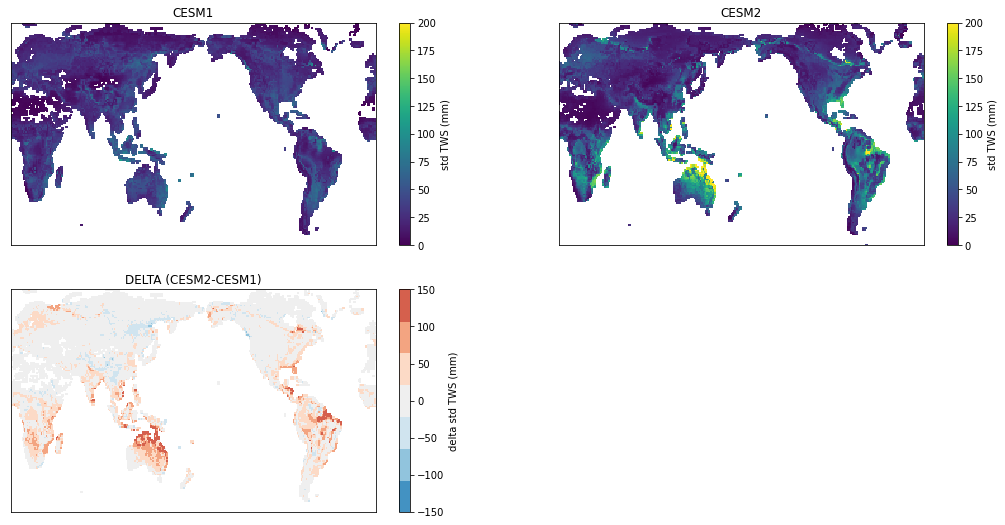

In [112]:
plt.figure(figsize=[18,9])
plt.subplot(221)
plt.pcolormesh(tw1,vmin=0,vmax=200)
plt.colorbar(label='std TWS (mm)')
plt.ylim([30,180])
plt.xticks([])
plt.yticks([])
plt.title('CESM1')

plt.subplot(222)
plt.pcolormesh(tw2,vmin=0,vmax=200)
plt.colorbar(label='std TWS (mm)')
plt.ylim([30,180])
plt.xticks([])
plt.yticks([])
plt.title('CESM2')

plt.subplot(223)
plt.pcolormesh(tw2-tw1,vmin=-150,vmax=150,cmap=ccc2)
plt.colorbar(label='delta std TWS (mm)')
plt.ylim([30,180])
plt.xticks([])
plt.yticks([])
plt.title('DELTA (CESM2-CESM1)');

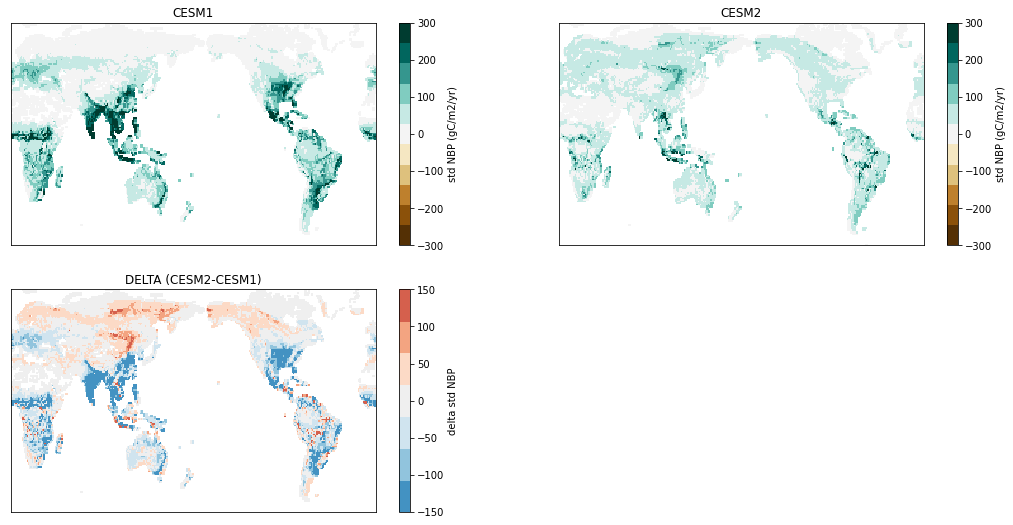

In [111]:
plt.figure(figsize=[18,9])
plt.subplot(221)
plt.pcolormesh(nb1,vmin=-300,vmax=300,cmap=ccc)
plt.colorbar(label='std NBP (gC/m2/yr)')
plt.ylim([30,180])
plt.xticks([])
plt.yticks([])
plt.title('CESM1')

plt.subplot(222)
plt.pcolormesh(nb2,vmin=-300,vmax=300,cmap=ccc)
plt.colorbar(label='std NBP (gC/m2/yr)')
plt.ylim([30,180])
plt.xticks([])
plt.yticks([])
plt.title('CESM2')

plt.subplot(223)
plt.pcolormesh(nb2-nb1,vmin=-150,vmax=150,cmap=ccc2)
plt.colorbar(label='delta std NBP')
plt.ylim([30,180])
plt.xticks([])
plt.yticks([])
plt.title('DELTA (CESM2-CESM1)');

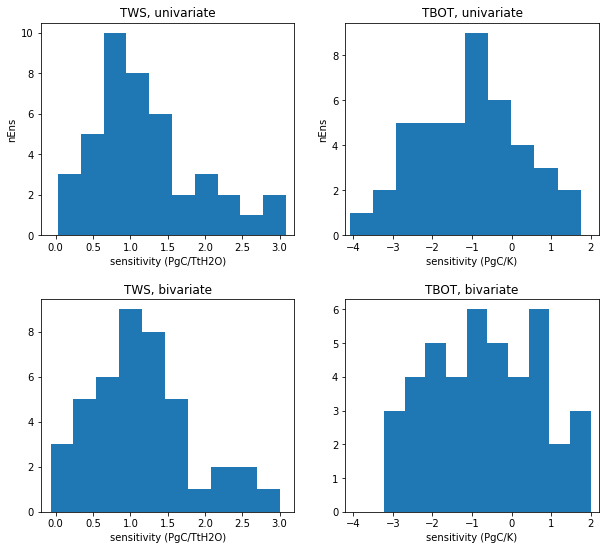

In [51]:
mtws1  = np.zeros(42)
mtws2  = np.zeros(42)
mtbot1 = np.zeros(42)
mtbot2 = np.zeros(42) 

i=0
for out in CESM1:
    xa1,xa2,ya,m1,m2,m = out[0]
    mtws1[i]  = m1
    mtws2[i]  = m[0,0]
    mtbot1[i] = m2
    mtbot2[i] = m[1,0]
    
    i += 1

plt.figure(figsize=[10,9])
plt.subplot(221)
plt.hist(mtws1)
plt.xlim([-0.2,3.2])
plt.title('TWS, univariate')
plt.xlabel('sensitivity (PgC/TtH2O)')
plt.ylabel('nEns')

plt.subplot(223)
plt.hist(mtws2)
plt.xlim([-0.2,3.2])
plt.title('TWS, bivariate')
plt.xlabel('sensitivity (PgC/TtH2O)')

plt.subplot(222)
plt.hist(mtbot1)
plt.xlim([-4.2,2.2])
plt.title('TBOT, univariate')
plt.ylabel('nEns')
plt.xlabel('sensitivity (PgC/K)')
plt.subplot(224)
plt.hist(mtbot2)
plt.xlim([-4.2,2.2]);
plt.title('TBOT, bivariate')
plt.xlabel('sensitivity (PgC/K)')
plt.subplots_adjust(hspace=0.3)

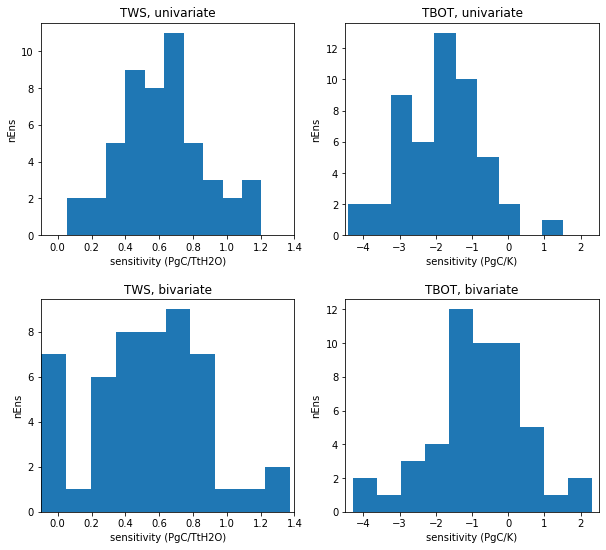

In [57]:
mtws1  = np.zeros(50)
mtws2  = np.zeros(50)
mtbot1 = np.zeros(50)
mtbot2 = np.zeros(50) 

i=0
for out in CESM2:
    xa1,xa2,ya,m1,m2,m = out[0]
    mtws1[i]  = m1
    mtws2[i]  = m[0,0]
    mtbot1[i] = m2
    mtbot2[i] = m[1,0]
    
    i += 1

plt.figure(figsize=[10,9])
plt.subplot(221)
plt.hist(mtws1)
plt.xlim([-0.1,1.4])
plt.title('TWS, univariate')
plt.xlabel('sensitivity (PgC/TtH2O)')
plt.ylabel('nEns')

plt.subplot(223)
plt.hist(mtws2)
plt.xlim([-0.1,1.4])
plt.title('TWS, bivariate')
plt.xlabel('sensitivity (PgC/TtH2O)')
plt.ylabel('nEns')

plt.subplot(222)
plt.hist(mtbot1)
plt.xlim([-4.5,2.5])
plt.title('TBOT, univariate')
plt.ylabel('nEns')
plt.xlabel('sensitivity (PgC/K)')

plt.subplot(224)
plt.hist(mtbot2)
plt.xlim([-4.5,2.5])
plt.ylabel('nEns')
plt.title('TBOT, bivariate')
plt.xlabel('sensitivity (PgC/K)')
plt.subplots_adjust(hspace=0.3)


In [47]:
mtws1  = np.zeros(42)
mtws2  = np.zeros(42)
mtbot1 = np.zeros(42)
mtbot2 = np.zeros(42) 

i=0
for out in CESM1:
    mw1,mw2,mb1,mb2,twswts,tbotwts,tws_anoms,tbot_anoms,nbp1_anoms = out[1]

    mavg1 = np.nansum(twswts*mw1)  # PgC / TtH2O
    mavg2 = np.nansum(twswts*mw2)  # PgC / TtH2O

    mavg3 = lnd_tot*1e6*1e-15*np.nansum(tbotwts*mb1) # PgC / K
    mavg4 = lnd_tot*1e6*1e-15*np.nansum(tbotwts*mb2) # PgC / K
    
    mtws1[i]  = mavg1
    mtws2[i]  = mavg2
    mtbot1[i] = mavg3
    mtbot2[i] = mavg4 
    
    i += 1

In [48]:
mtws12  = np.zeros(50)
mtws22  = np.zeros(50)
mtbot12 = np.zeros(50)
mtbot22 = np.zeros(50) 

i=0
for out in CESM2:
    mw1,mw2,mb1,mb2,twswts,tbotwts,tws_anoms,tbot_anoms,nbp1_anoms = out[1]

    mavg1 = np.nansum(twswts*mw1)  # PgC / TtH2O
    mavg2 = np.nansum(twswts*mw2)  # PgC / TtH2O

    mavg3 = lnd_tot*1e6*1e-15*np.nansum(tbotwts*mb1) # PgC / K
    mavg4 = lnd_tot*1e6*1e-15*np.nansum(tbotwts*mb2) # PgC / K
    
    mtws12[i]  = mavg1
    mtws22[i]  = mavg2
    mtbot12[i] = mavg3
    mtbot22[i] = mavg4 
    
    i += 1

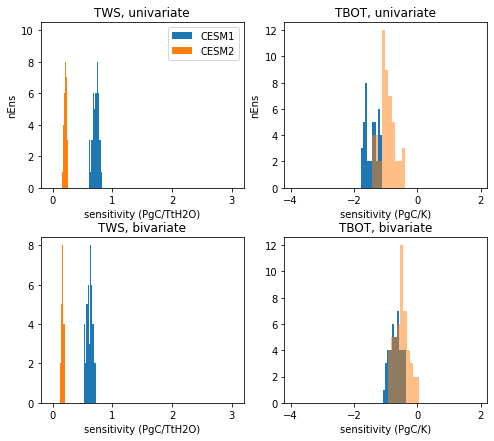

In [50]:
plt.figure(figsize=[8,7])
plt.subplot(221)
plt.hist(mtws1)
plt.hist(mtws12)
plt.xlim([-0.2,3.2])
plt.title('TWS, univariate')
plt.xlabel('sensitivity (PgC/TtH2O)')
plt.ylabel('nEns')
plt.legend(['CESM1','CESM2'])

plt.subplot(223)
plt.hist(mtws2)
plt.hist(mtws22)
plt.xlim([-0.2,3.2])
plt.title('TWS, bivariate')
plt.xlabel('sensitivity (PgC/TtH2O)')

plt.subplot(222)
plt.hist(mtbot1)
plt.hist(mtbot12,alpha=0.5)
plt.xlim([-4.2,2.2])
plt.title('TBOT, univariate')
plt.ylabel('nEns')
plt.xlabel('sensitivity (PgC/K)')
plt.subplot(224)
plt.hist(mtbot2)
plt.hist(mtbot22,alpha=0.5)
plt.xlim([-4.2,2.2]);
plt.title('TBOT, bivariate')
plt.xlabel('sensitivity (PgC/K)')
plt.subplots_adjust(hspace=0.3)

### What explains the difference between VH sensitivity and DK sensitivity?
 1. Coding error?
 2. Weighting error?
 3. Effect of correlated slopes?
 4. Effect of correlated errors?

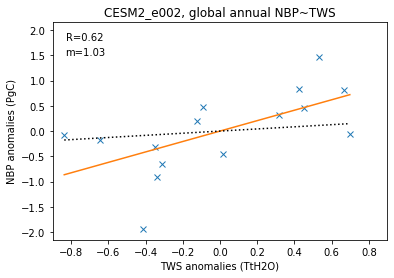

In [78]:
out = CESM2[2]
xa1,xa2,ya,m1,m2,m = out[0]
mtws1,mtws2,mtbot1,mtbot2,twswts,tbotwts,tws_anoms,tbot_anoms,nbp1_anoms = out[1]

mavg = np.nansum(mtws1*twswts)

plt.plot(xa1,ya,'x')
xfit = np.array([xa1.min(),xa1.max()])
r = np.corrcoef(xa1.ravel(),ya.ravel())[0,1]
plt.plot(xfit,m1[0,0]*xfit)
plt.plot(xfit,mavg*xfit,'k:')
plt.xlabel('TWS anomalies (TtH2O)')
plt.ylabel('NBP anomalies (PgC)')
plt.ylim([-2.15,2.15])
plt.xlim([-0.9,0.9])
plt.text(-0.83,1.8,'R='+str(np.round(r,2)))
plt.text(-0.83,1.5,'m='+str(np.round(m1[0,0],2)))
plt.title('CESM2_e002, global annual NBP~TWS');

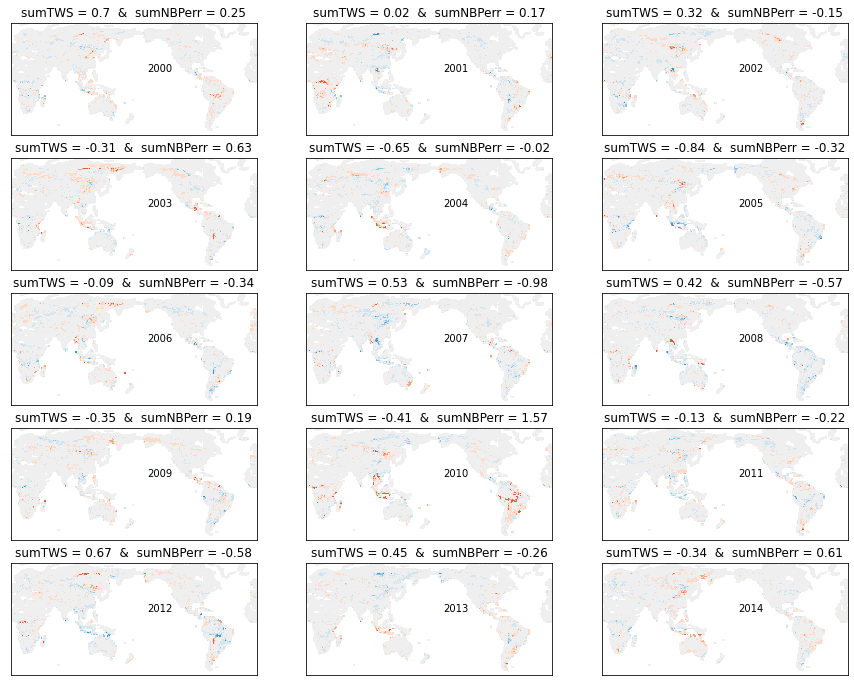

In [20]:
plt.figure(figsize=[15,12])
x = np.zeros(15)
y = np.zeros(15)
for yy in range(15):
    plt.subplot(5,3,yy+1)
    nbp = nbp1_anoms[:,:,yy]
    nbp_lm = mtws1*tws_anoms[:,:,yy]
    nbp_err = nbp_lm-nbp
    plt.pcolormesh(nbp_err,vmin=-400,vmax=400,cmap=ccc2)

    plt.ylim([30,180])
    plt.xticks([])
    plt.yticks([])
    ee = np.nansum(1e6*1e-15*landarea*nbp_lm)-ya[yy,0]
    plt.title('sumTWS = '+str(np.round(xa1[yy,0],2))+'  &  sumNBPerr = '+str(np.round(ee,2)));

    x[yy] = xa1[yy,0]
    y[yy] = ee
    
    plt.text(160,115,yy+2000)
    

In [24]:
np.sum(y)

8.37108160567368e-14

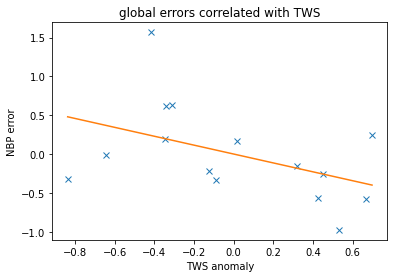

In [22]:
G = np.zeros([15,1])
G[:,0] = x
d = y.reshape([-1,1])
[m,sumr,r,s] = np.linalg.lstsq(G,d,rcond=None)
xfit = np.array([x.min(),x.max()])
yfit = m[0,0]*xfit
plt.plot(x,y,'x')
plt.plot(xfit,yfit)
plt.xlabel('TWS anomaly')
plt.ylabel('NBP error')
plt.title('global errors correlated with TWS');

In [128]:
x = np.zeros(50*15)
y = np.zeros(50*15)
i = 0
for out in CESM2:
    xa1,xa2,ya,m1,m2,m = out[0]
    mtws1,mtws2,mtbot1,mtbot2,twswts,tbotwts,tws_anoms,tbot_anoms,nbp1_anoms = out[1]
    
    for yy in range(15):
        y[i] = np.nansum(1e6*1e-15*landarea*nbp_lm)-ya[yy,0]
        x[i] = xa1[yy,0]
    
        i +=1

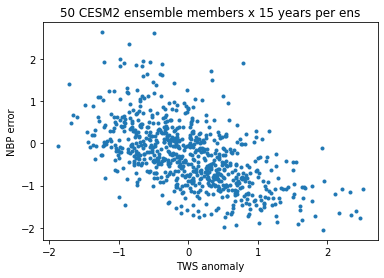

In [130]:
plt.plot(x,y,'.')
plt.xlabel('TWS anomaly')
plt.ylabel('NBP error')
plt.title('50 CESM2 ensemble members x 15 years per ens');

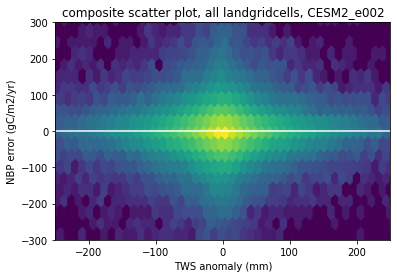

In [26]:
ee=2
out = CESM2[ee]
xa1,xa2,ya,m1,m2,m = out[0]
mtws1,mtws2,mtbot1,mtbot2,twswts,tbotwts,tws_anoms,tbot_anoms,nbp1_anoms = out[1]
nbp_lm = mtws1[:,:,np.newaxis]*tws_anoms
nbp_err = nbp_lm-nbp1_anoms
ix = ~np.isnan(nbp_err)
nl = np.sum(ix)
G = np.zeros([nl,1])
G[:,0] = tws_anoms[ix]
d = nbp_err[ix].reshape([-1,1])
[m,sumr,r,s] = np.linalg.lstsq(G,d,rcond=None)
plt.hexbin(tws_anoms[ix],nbp_err[ix],bins='log')
xfit = np.array([-250,250])
plt.plot(xfit,m[0,0]*xfit,'w-')
plt.xlim([-250,250])
plt.ylim([-300,300])
plt.xlabel('TWS anomaly (mm)')
plt.ylabel('NBP error (gC/m2/yr)')
plt.title('composite scatter plot, all landgridcells, CESM2_e002');

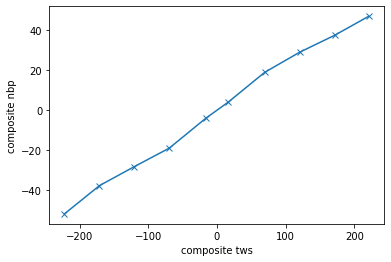

In [34]:
xv = np.linspace(-250,250,11)
nx = len(xv)-1
x = np.zeros(nx)
y = np.zeros(nx)

ix = ~np.isnan(nbp1_anoms)
xx = tws_anoms[ix]
yy = nbp1_anoms[ix]
for i in range(nx):
    ix = np.logical_and(xx>xv[i],xx<=xv[i+1])
    x[i] = np.mean(xx[ix])
    y[i] = np.mean(yy[ix])
    
plt.plot(x,y,'-x')
plt.xlabel('composite tws')
plt.ylabel('composite nbp');

In [45]:
ccc3 = np.zeros([6,3]);
ccc3[0,:] = 245,245,245
ccc3[1,:] = 199,234,229
ccc3[2,:] = 128,205,193
ccc3[3,:] = 53,151,143
ccc3[4,:] = 1,102,94
ccc3[5,:] = 0,60,48
ccc3 = matplotlib.colors.ListedColormap(ccc3/256)

In [43]:
x = np.zeros(50*15)
y = np.zeros(50*15)
errmap = np.zeros([nlat,nlon])
i = 0
for out in CESM2:
    xa1,xa2,ya,m1,m2,m = out[0]
    mtws1,mtws2,mtbot1,mtbot2,twswts,tbotwts,tws_anoms,tbot_anoms,nbp1_anoms = out[1]

    thiserr = landarea*(abs(mtws1[:,:,np.newaxis]*tws_anoms)).sum(axis=2)
    errmap = errmap+thiserr

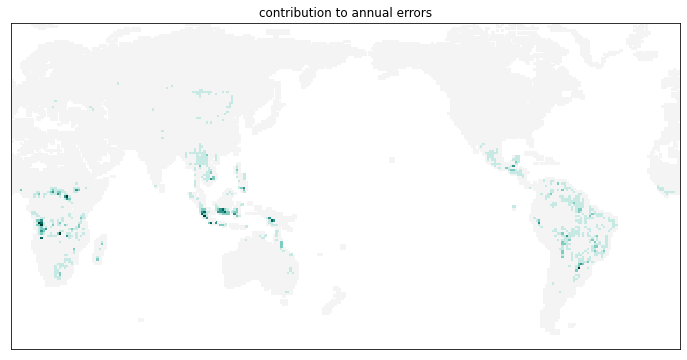

In [53]:
plt.figure(figsize=[12,6])
plt.pcolormesh(errmap,cmap=ccc3)
plt.ylim([30,180])
plt.xticks([])
plt.yticks([])
plt.title('contribution to annual errors');

In [13]:
model = 'CESM1'
if model=='CESM2':
    soildim = 'levsoi'
    yy    = 1999
else:
    soildim = 'levgrnd'
    yy = 1990
ds1   = get_field(1,model,'NBP')
ds2   = get_field(1,model,'SOILLIQ')
ixt   = ds1['time.year']>yy
nbp   = ds1['NBP'].isel(time=ixt)
tws   = ds2['SOILLIQ'].isel(time=ixt).sum(dim=soildim)
ix1 = tws.std(dim='time').values.ravel()>0
ix2 = nbp.std(dim='time').values.ravel()>0
ixlnd   = np.logical_and(ix1,ix2)
nlat  = len(ds1['lat'])
nlon  = len(ds1['lon'])
latmap = np.tile(np.arange(nlat).reshape([-1,1]),[1,nlon]).ravel()
lonmap = np.tile(np.arange(nlon).reshape([1,-1]),[nlat,1]).ravel()
lats = latmap[ixlnd]
lons = lonmap[ixlnd]
if model=='CESM2':
    landarea = ds1['area'].isel(time=0)*ds2['landfrac'].isel(time=0) #km2
else:
    landarea = ds1['area']*ds2['landfrac'] #km2
conv_nbp = 24*60*60*1e-15  # PgC
conv_tws = 1000/365*1e-18  # TtH20

print(model)

CESM1


/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


In [14]:
print(model)
def myfunc_CESM1(ee):
    yy = 1990
    #stuff to do once per ensemble member
    ds1   = get_field(ee,model,'NBP')
    ds2   = get_field(ee,model,'SOILLIQ')
    ixt   = ds1['time.year']>yy
    nbp   = ds1['NBP'].isel(time=ixt)
    tws   = ds2['SOILLIQ'].isel(time=ixt).sum(dim=soildim)
    twsann = (mth_wts/365*tws).groupby('time.year').sum().load()        #mmH2O
    twsann_glob = 1e-15*1e6*((landarea*twsann).sum(dim=['lat','lon']))  #TTH20
    nbpann = 24*60*60*(mth_wts*nbp).groupby('time.year').sum().load()   #gC/m2/yr
    nbpann_glob = 1e-15*1e6*((landarea*nbpann).sum(dim=['lat','lon'])).load()
    bigx,bigy,bigm,R = one_regression(twsann_glob.values,nbpann_glob.values)
    twsvar  = twsann.var(dim='year')
    wts = twsvar*landarea
    wts = wts.fillna(0)
    wts = wts/wts.sum()
    wts = wts.values
    
    #the big, bad loop
    mvals = np.zeros([nlat,nlon])+np.nan
    rvals = np.zeros([nlat,nlon])+np.nan
    twsanoms = np.zeros([nlat,nlon,nyears])+np.nan
    nbpanoms = np.zeros([nlat,nlon,nyears])+np.nan

    for i,j in zip(lats,lons):
        x = twsann[:,i,j].values
        y = nbpann[:,i,j].values
        xa,ya,m,R = one_regression(x,y)
        mvals[i,j] = m
        rvals[i,j] = m
        twsanoms[i,j,:] = xa.ravel()
        nbpanoms[i,j,:] = ya.ravel()
        
    return bigx,bigy,bigm,mvals,wts,twsanoms,nbpanoms

CESM1


In [15]:
%%time
with joblib.parallel_backend('dask'):
    x1 = Parallel()(delayed(myfunc_CESM1)(ee) for ee in range(21))
with joblib.parallel_backend('dask'):
    x2 = Parallel()(delayed(myfunc_CESM1)(ee) for ee in 21+np.arange(21))
CESM1 = x1+x2

CPU times: user 3.95 s, sys: 1.87 s, total: 5.82 s
Wall time: 1min 1s


In [16]:
model = 'CESM2'
if model=='CESM2':
    soildim = 'levsoi'
    yy    = 1999
else:
    soildim = 'levgrnd'
    yy = 1990
ds1   = get_field(1,model,'NBP')
ds2   = get_field(1,model,'SOILLIQ')
ixt   = ds1['time.year']>yy
nbp   = ds1['NBP'].isel(time=ixt)
tws   = ds2['SOILLIQ'].isel(time=ixt).sum(dim=soildim)
ix1 = tws.std(dim='time').values.ravel()>0
ix2 = nbp.std(dim='time').values.ravel()>0
ixlnd   = np.logical_and(ix1,ix2)
nlat  = len(ds1['lat'])
nlon  = len(ds1['lon'])
latmap = np.tile(np.arange(nlat).reshape([-1,1]),[1,nlon]).ravel()
lonmap = np.tile(np.arange(nlon).reshape([1,-1]),[nlat,1]).ravel()
lats = latmap[ixlnd]
lons = lonmap[ixlnd]
if model=='CESM2':
    landarea = ds1['area'].isel(time=0)*ds2['landfrac'].isel(time=0) #km2
else:
    landarea = ds1['area']*ds2['landfrac'] #km2
conv_nbp = 24*60*60*1e-15  # PgC
conv_tws = 1000/365*1e-18  # TtH20
days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
nyears   = 15
mth_wts  = xr.DataArray(np.tile(days_pm,nyears),dims='time')
print(model)

CESM2


/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


In [17]:
print(model)
def myfunc_CESM2(ee):
    yy = 1999
    #stuff to do once per ensemble member
    ds1   = get_field(ee,model,'NBP')
    ds2   = get_field(ee,model,'SOILLIQ')
    ixt   = ds1['time.year']>yy
    nbp   = ds1['NBP'].isel(time=ixt)
    tws   = ds2['SOILLIQ'].isel(time=ixt).sum(dim=soildim)
    twsann = (mth_wts/365*tws).groupby('time.year').sum().load()        #mmH2O
    twsann_glob = 1e-15*1e6*((landarea*twsann).sum(dim=['lat','lon']))  #TTH20
    nbpann = 24*60*60*(mth_wts*nbp).groupby('time.year').sum().load()   #gC/m2/yr
    nbpann_glob = 1e-15*1e6*((landarea*nbpann).sum(dim=['lat','lon'])).load()
    bigx,bigy,bigm,R = one_regression(twsann_glob.values,nbpann_glob.values)
    twsvar  = twsann.var(dim='year')
    wts = twsvar*landarea
    wts = wts.fillna(0)
    wts = wts/wts.sum()
    wts = wts.values
    
    #the big, bad loop
    mvals = np.zeros([nlat,nlon])+np.nan
    rvals = np.zeros([nlat,nlon])+np.nan
    twsanoms = np.zeros([nlat,nlon,nyears])+np.nan
    nbpanoms = np.zeros([nlat,nlon,nyears])+np.nan

    for i,j in zip(lats,lons):
        x = twsann[:,i,j].values
        y = nbpann[:,i,j].values
        xa,ya,m,R = one_regression(x,y)
        mvals[i,j] = m
        rvals[i,j] = m
        twsanoms[i,j,:] = xa.ravel()
        nbpanoms[i,j,:] = ya.ravel()
        
    return bigx,bigy,bigm,mvals,wts,twsanoms,nbpanoms

CESM2


In [18]:
%%time
with joblib.parallel_backend('dask'):
    x1 = Parallel()(delayed(myfunc_CESM2)(ee) for ee in range(25))
with joblib.parallel_backend('dask'):
    x2 = Parallel()(delayed(myfunc_CESM2)(ee) for ee in 25+np.arange(25))
CESM2 = x1+x2

distributed.scheduler - ERROR - Couldn't gather keys {"('stack-8434509b6909c724af6ebee1f25b3f16', 11, 0, 0)": [], "('stack-8434509b6909c724af6ebee1f25b3f16', 10, 0, 0)": [], "('stack-8434509b6909c724af6ebee1f25b3f16', 14, 0, 0)": [], "('stack-8434509b6909c724af6ebee1f25b3f16', 12, 0, 0)": [], "('stack-8434509b6909c724af6ebee1f25b3f16', 13, 0, 0)": []} state: ['waiting', 'waiting', 'waiting', 'waiting', 'waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('stack-8434509b6909c724af6ebee1f25b3f16', 11, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('stack-8434509b6909c724af6ebee1f25b3f16', 10, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('stack-8434509b6909c724af6ebee1f25b3f16', 14, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('stack-8434509b6909c724af6ebee1f25b3f16', 12, 0, 0)
NoneType: None
distribu

CPU times: user 9.79 s, sys: 2.72 s, total: 12.5 s
Wall time: 1min 15s


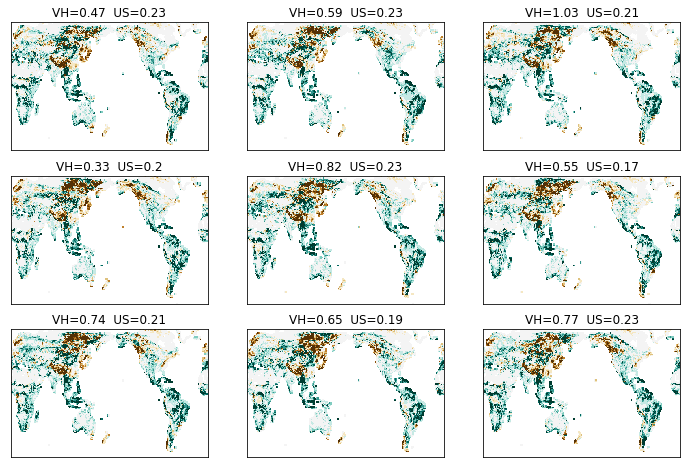

In [19]:
plt.figure(figsize=[12,8])
for i in range(9):
    plt.subplot(3,3,i+1)
    out = CESM2[i][3]
    m   = CESM2[i][2]
    wts = CESM2[i][4]
    m2  = np.nansum(wts*out)
    plt.pcolormesh(out,vmin=-1.5,vmax=1.5,cmap=ccc)
    plt.ylim([30,175])
    plt.xticks([])
    plt.yticks([])
    plt.title('VH='+str(np.round(m,2))+'  US='+str(np.round(m2,2)))

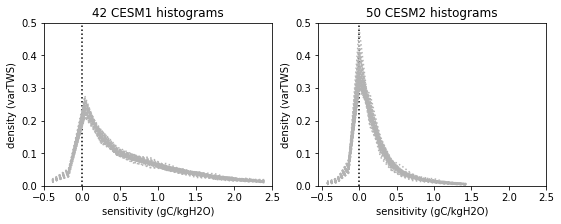

In [21]:
plt.figure(figsize=[9,3])
plt.subplot(121)
plt.plot([0,0],[0,0.5],'k:',linewidth=1.5)
for ee in range(42):
    mvals = CESM1[ee][3]
    wts = CESM1[ee][4]
    xv = np.linspace(-0.5,2.5,15)
    x  = 0.5*(xv[1:]+xv[:-1])
    nx = len(xv)-1
    yv = np.zeros(nx)

    for i in range(nx):
        ix = np.logical_and(mvals>xv[i],mvals<=xv[i+1])
        yv[i] = np.sum(wts[ix])

    plt.plot(x,yv,':',color=[0.7,0.7,0.7])
plt.title('42 CESM1 histograms')
plt.xlabel('sensitivity (gC/kgH2O)')
plt.ylabel('density (varTWS)');
plt.xlim([-0.5,2.5])
plt.ylim([0,0.5])
    
    
plt.subplot(122)
plt.plot([0,0],[0,0.5],'k:',linewidth=1.5)
for ee in range(50):
    mvals = CESM2[ee][3]
    wts = CESM2[ee][4]
    xv = np.linspace(-0.5,1.5,15)
    x  = 0.5*(xv[1:]+xv[:-1])
    nx = len(xv)-1
    yv = np.zeros(nx)

    for i in range(nx):
        ix = np.logical_and(mvals>xv[i],mvals<=xv[i+1])
        yv[i] = np.sum(wts[ix])

    plt.plot(x,yv,':',color=[0.7,0.7,0.7])


plt.title('50 CESM2 histograms')
plt.xlabel('sensitivity (gC/kgH2O)')
plt.ylabel('density (varTWS)')
plt.xlim([-0.55,2.5])
plt.ylim([0,0.5]);

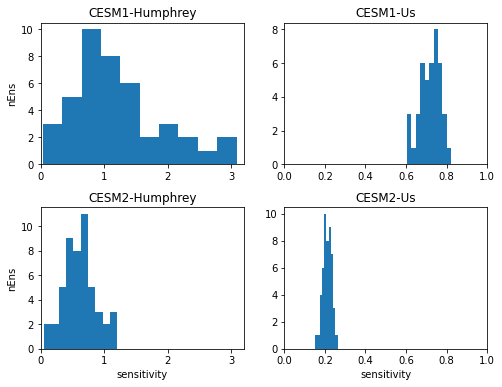

In [22]:
plt.figure(figsize=[8,6])
plt.subplot(221)
m = [CESM1[ee][2] for ee in range(42)]
plt.hist(m)
plt.xlim([0,3.2])
plt.title('CESM1-Humphrey')
plt.ylabel('nEns')

plt.subplot(222)
m2 = np.zeros(42)
for ee in range(42):
    wts = CESM1[ee][4]
    mvals = CESM1[ee][3]
    m2[ee] = np.nansum(wts*mvals)
plt.hist(m2)
plt.xlim([0,1])
plt.title('CESM1-Us')


plt.subplot(223)
m = [CESM2[ee][2] for ee in range(50)]
plt.hist(m)
plt.xlim([0,3.2])
plt.title('CESM2-Humphrey')
plt.ylabel('nEns')
plt.xlabel('sensitivity')
plt.subplot(224)
m2 = np.zeros(50)
for ee in range(50):
    wts = CESM2[ee][4]
    mvals = CESM2[ee][3]
    m2[ee] = np.nansum(wts*mvals)
plt.hist(m2)
plt.xlim([0,1])
plt.title('CESM2-Us')
plt.xlabel('sensitivity');
plt.subplots_adjust(hspace=0.3)

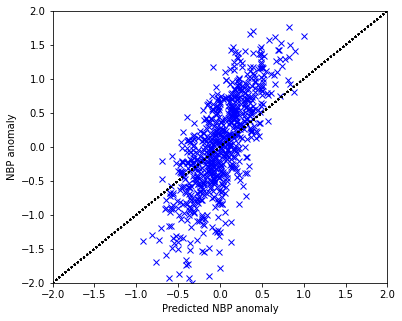

In [16]:
#look at linear model predictions vs. actual NBP anomalies, year-by-year, ens-by-ens

ds = get_field(2,'CESM2','NBP')
landarea = ds['area'].isel(time=0)*ds['landfrac'].isel(time=0) #km2
landarea = landarea.values[:,:,np.newaxis]

plt.figure(figsize=[6,5])
for ee in range(50):


    bigx,bigy,bigm,mvals,wts,twsanoms,nn = CESM2[ee]
    nbpanoms = np.nansum(1e6*1e-15*landarea*(mvals[:,:,np.newaxis]*twsanoms),axis=(0,1))   #gc/m2/yr

    plt.plot([-2,2],[-2,2],'k:')
    plt.plot(nbpanoms,bigy,'bx')
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    plt.ylabel('NBP anomaly')
    plt.xlabel('Predicted NBP anomaly')


### explanation candidates?
 - coding error
 - spatial correlation in slopes
 - strong spatial correlation in residuals
 - (non-linear) structure in residuals

In [78]:
bigx,bigy,bigm,mvals,wts,twsanoms,nbpanoms = CESM2[2]

In [112]:
ix1 = np.std(twsanoms,axis=2)>0
ix2 = np.std(nbpanoms,axis=2)>0
ix  = np.logical_and(ix1,ix2)
tws = twsanoms[ix]
m   = mvals[ix].reshape([-1,1])
nbp_m = (m*tws).ravel()
nbp = nbpanoms[ix].ravel()
tws = tws.ravel()
err = nbp_m-nbp
m, b, r_value, p_value, std_err = stats.linregress(tws,err)
print(m)
print(b)

5.3750057652112044e-18
3.579176661696144e-14


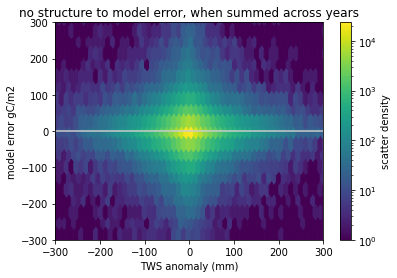

In [117]:
plt.hexbin(tws,err,bins='log')
xfit = np.array([-300,300])
plt.plot(xfit,m*xfit+b,color=[0.8,0.8,0.8])
plt.colorbar(label='scatter density')
plt.xlim([-300,300])
plt.ylim([-300,300])
plt.xlabel('TWS anomaly (mm)')
plt.ylabel('model error gC/m2')
plt.title('no structure to model error, when summed across years');

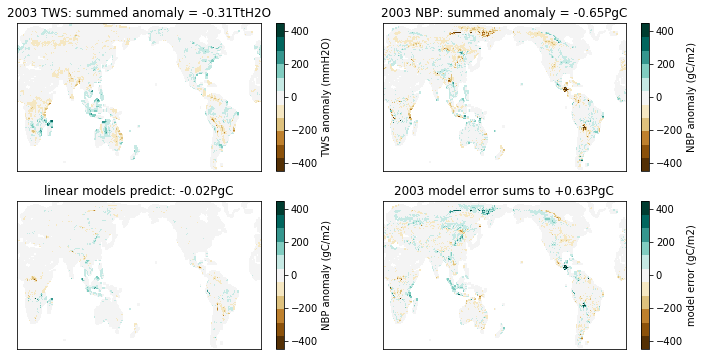

In [174]:
bigx,bigy,bigm,mvals,wts,twsanoms,nbpanoms = CESM2[2]
yy = 3
plt.figure(figsize=[12,6])
plt.subplot(221)
plt.pcolormesh(twsanoms[:,:,yy],cmap=ccc,vmin=-450,vmax=450)
plt.ylim([35,175])
plt.yticks([])
plt.xticks([])
plt.colorbar(label='TWS anomaly (mmH2O)')
plt.title(str(2000+yy)+' TWS: summed anomaly = '+str(np.round(bigx[yy][0],2))+'TtH2O');

plt.subplot(222)
plt.pcolormesh(nbpanoms[:,:,yy],cmap=ccc,vmax=450,vmin=-450)
plt.ylim([35,175])
plt.yticks([])
plt.xticks([])
plt.colorbar(label='NBP anomaly (gC/m2)')
plt.title(str(2000+yy)+' NBP: summed anomaly = '+str(np.round(bigy[yy][0],2))+'PgC');

tws = twsanoms[:,:,yy]
nbp1 = mvals*tws
nbp2 = nbpanoms[:,:,yy]
totanom = 1e-9*np.nansum(lnd*nbp1[ix])
plt.subplot(223)
plt.pcolormesh(nbp1,cmap=ccc,vmax=450,vmin=-450)
plt.ylim([35,175])
plt.yticks([])
plt.xticks([])
plt.colorbar(label='NBP anomaly (gC/m2)')
plt.title('linear models predict: '+str(np.round(totanom,2))+'PgC');

yy = 3
tws = twsanoms[:,:,yy]
nbp1 = mvals*tws
nbp2 = nbpanoms[:,:,yy]
plt.subplot(224)
plt.pcolormesh(nbp1-nbp2,cmap=ccc,vmin=-450,vmax=450)
plt.ylim([35,175])
plt.yticks([])
plt.xticks([])
plt.colorbar(label='model error (gC/m2)')
plt.title(str(2000+yy)+' model error sums to +0.63PgC');


In [132]:
lnd = landarea.values[ix]
for i in range(15):
    y1 = (mvals*twsanoms[:,:,i])[ix]
    y2 = nbpanoms[:,:,i][ix]
    err = y1-y2
    summed_err = np.nansum(1e-9*lnd*err)
    print(summed_err)

0.2461640854169283
0.16998495753488485
-0.14838178502269211
0.6342737483626354
-0.018285247196500043
-0.32353943760430864
-0.33587016110150125
-0.9771054504832626
-0.566984521911041
0.1921536328543491
1.5683680996544807
-0.21670729286490487
-0.5753968165420849
-0.2625425226524745
0.6138687115555761


In [127]:
ix1 = np.std(twsanoms,axis=2)>0
ix2 = np.std(nbpanoms,axis=2)>0
ix  = np.logical_and(ix1,ix2)

In [134]:
bigx[3]

array([-0.30931669])

### try TBOT and TWS together

In [12]:
ee = 2
model = 'CESM2'
soildim = 'levsoi'
ds1   = get_field(ee,model,'NBP')
ds2   = get_field(ee,model,'SOILLIQ')
ds3 = get_field(ee,model,'TBOT')
ixt   = ds1['time.year']>1999
nbp   = ds1['NBP'].isel(time=ixt)
tws   = ds2['SOILLIQ'].isel(time=ixt).sum(dim=soildim)
tbot  = ds3['TBOT'].isel(time=ixt) 

In [28]:
days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
nyears   = 15
mth_wts  = xr.DataArray(np.tile(days_pm,nyears),dims='time')
twsann   = (mth_wts/365*tws).groupby('time.year').sum().load()        #mmH2O
tbotann  = (mth_wts/365*tbot).groupby('time.year').sum().load()        #K
nbpann   = 24*60*60*(mth_wts*nbp).groupby('time.year').sum().load()   #gC/m2/yr

In [21]:
ix1 = tws.std(dim='time').values.ravel()>0
ix2 = nbp.std(dim='time').values.ravel()>0
ix3 = tbot.std(dim='time').values.ravel()>0
ixlnd   = np.logical_and(ix1,ix2)
ixlnd   = np.logical_and(ix3,ixlnd)
nlat  = len(ds1['lat'])
nlon  = len(ds1['lon'])
latmap = np.tile(np.arange(nlat).reshape([-1,1]),[1,nlon]).ravel()
lonmap = np.tile(np.arange(nlon).reshape([1,-1]),[nlat,1]).ravel()
lats = latmap[ixlnd]
lons = lonmap[ixlnd]

In [68]:
tws_m  = np.zeros([nlat,nlon])+np.nan
tbot_m = np.zeros([nlat,nlon])+np.nan
bvals  = np.zeros([nlat,nlon])+np.nan

for ii in range(len(lats)):
    i = lats[ii]
    j = lons[ii]
    x1 = twsann[:,i,j].values
    x2 = tbotann[:,i,j].values
    y  = nbpann[:,i,j].values

    xa1,xa2,ya,m = two_regression(x1,x2,y)
    tws_m[i,j]   = m[1,0]
    tbot_m[i,j]  = m[2,0]
    bvals[i,j]   = m[0,0]


In [100]:
twsstd  = twsann.std(dim='year').load()
tbotstd = tbotann.std(dim='year').load()
tws_effect  = abs(tws_m*twsstd)
tbot_effect = abs(tbot_m*tbotstd)

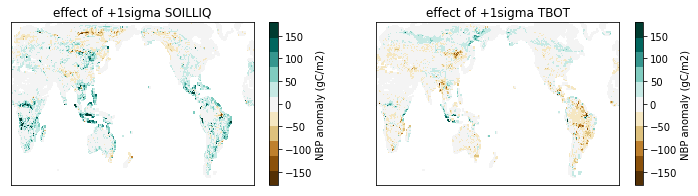

In [86]:
plt.figure(figsize=[12,3])
plt.subplot(121)
plt.pcolormesh(tws_m*twsstd,cmap=ccc,vmin=-180,vmax=180)
plt.ylim([30,175])
plt.yticks([])
plt.xticks([])
plt.colorbar(label='NBP anomaly (gC/m2)')
plt.title('effect of +1sigma SOILLIQ');
plt.subplot(122)
plt.pcolormesh(tbot_m*tbotstd,cmap=ccc,vmin=-180,vmax=180)
plt.ylim([30,175])
plt.yticks([])
plt.xticks([])
plt.colorbar(label='NBP anomaly (gC/m2)')
plt.title('effect of +1sigma TBOT');

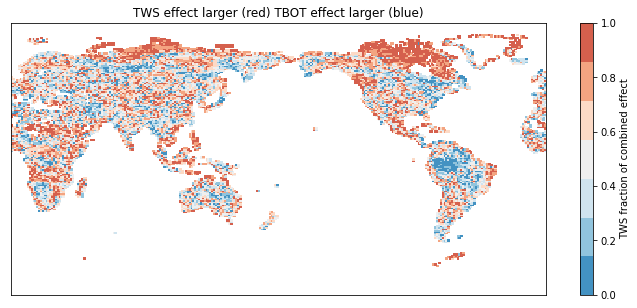

In [106]:
frac_tws = tws_effect/(tws_effect+tbot_effect)
plt.figure(figsize=[12,5])
plt.pcolormesh(frac_tws,vmin=0,vmax=1,cmap=ccc2)
plt.colorbar(label='TWS fraction of combined effect')
plt.xticks([])
plt.yticks([])
plt.title('TWS effect larger (red) TBOT effect larger (blue)');

### look at how the combined predictions perform
 - and/or look at how the var(TWS) var(TBOT) slope estimates compare to global values

### use 30 years
 - will have to adjust get_files, get_field

In [109]:
ee = 2
model = 'CESM2'
soildim = 'levsoi'
ds1   = get_field(ee,model,'NBP')
ds2   = get_field(ee,model,'SOILLIQ')
ds3 = get_field(ee,model,'TBOT')
ixt   = ds1['time.year']>1984
nbp   = ds1['NBP'].isel(time=ixt)
tws   = ds2['SOILLIQ'].isel(time=ixt).sum(dim=soildim)
tbot  = ds3['TBOT'].isel(time=ixt) 

In [110]:
ds1['time.year'][ixt]

<xarray.DataArray 'year' (time: 180)>
array([2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000,
       2000, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001,
       2001, 2001, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002,
       2002, 2002, 2002, 2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003,
       2003, 2003, 2003, 2003, 2004, 2004, 2004, 2004, 2004, 2004, 2004,
       2004, 2004, 2004, 2004, 2004, 2005, 2005, 2005, 2005, 2005, 2005,
       2005, 2005, 2005, 2005, 2005, 2005, 2006, 2006, 2006, 2006, 2006,
       2006, 2006, 2006, 2006, 2006, 2006, 2006, 2007, 2007, 2007, 2007,
       2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2008, 2008, 2008,
       2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2009, 2009,
       2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2010,
       2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010,
       2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011,
       2011, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012,
       2012, 2012, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013,
       2013, 2013, 2013, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014,
       2014, 2014, 2014, 2014])
Coordinates:
  * time     (time) object 2000-01-16 00:00:00 ... 2014-12-16 00:00:00